# Notebook 26 — Opening Recommender Model: Training Pipeline

### 0. Overview and Goals

This notebook defines the full pipeline for training the chess opening recommender model.  
The objective is to predict **player–opening performance scores** ((wins + (0.5 * draws) / num games)) for openings a player hasn’t yet played, based on their results in the openings they *have* played.  

The model will use **matrix factorization** with **stochastic gradient descent (SGD)** to learn latent factors representing player and opening characteristics.  
All computations will be implemented in **PyTorch**, with data loaded from my local **DuckDB** database.

**High-level specs:**
- Use only *White* openings initially (we’ll extend to Black later).  
- Data source: processed player–opening stats from local DuckDB.  
- Predict: normalized “score” = win rate ((wins + 0.5 x draws) / total games).  
- Filter: only include entries with ≥ `MIN_GAMES_THRESHOLD` (default = 50).  
- Ignore: rating differences, time controls, and other metadata.  
- Model parameters (to be defined in appropriate places for easy editing):  
  - `NUM_FACTORS`, `LEARNING_RATE`, `BATCH_SIZE`, `N_EPOCHS`, `NUM_PLAYERS_TO_PROCESS`  
- Logging and checkpoints throughout for reproducibility.  
- All random operations seeded for deterministic runs.  

---

### 1. Data Extraction
- Connect to local DuckDB
- Pull all processed player–opening statistics from
- Verify schema consistency:  
  - Required columns: `player_id`, `opening_id`, `eco`, `num_games`, `wins`, `draws`, `losses`.  
- Include a row-count sanity check.
- Only players with ratings above 1200

---

### 2. Data Sanitization & Normalization
- Optionally normalize scores if needed for MF convergence.  
- Drop players with no qualifying openings and openings with no qualifying players.  
  - I believe there shouldn't be any but we'll double check.
- Resequence player_id and opening_id to be sequential integers - right now there are gaps because of entries we deleted from the DB 
- Check for sparsity consistency (no implicit zeros yet).  
- Note that this data has already been split in to white and black games further up the pipeline

### Data Quality
- Drop entries with fewer than `MIN_GAMES_THRESHOLD` games
- Handle any duplicate `(player_id, opening_id)` combinations
- Remove players with no qualifying openings
- Remove openings with no qualifying players
- Verify no null values remain

### ECO Codes
- Keep ECO codes for later categorical encoding (Step 4)
- ECO will be used as opening side information (similar to rating for players)

### Confidence Weighting
- Use `MIN_GAMES_THRESHOLD = 10` to keep more data
- Add a **confidence weight** column: `confidence = num_games / (num_games + K)` where K ≈ 50
- This weight will be used in the loss function to down-weight uncertain predictions
- High-game-count entries → high confidence → larger loss impact
- Low-game-count entries → low confidence → smaller loss impact

### Player Rating (Side Information)
- **Player ratings are side information** - they describe player characteristics, not individual player-opening interactions
- Ratings will be stored separately and joined to player embeddings during training
- We'll **normalize ratings** (likely z-score normalization) to avoid scaling issues with the embedding layer
- Rating normalization will be done once after extraction, not per-row

---

### 3. Data Splits
- Split into train/test/val sets.  
- Ensure every player and every opening appears at least once in the training data.  
- Strategy:  
  - Sample unique players and openings to guarantee coverage in train.  
  - Remaining data → stratified random split into train/test.  
  - Deduplicate and merge unique IDs back into train if needed.

---

### 4. Enumerate Categorical Variables
- Enumerate `eco` (if included) as an integer categorical variable.  
- Confirm all columns are numeric and compatible with PyTorch tensors.  
- Verify no missing or out-of-range IDs.

---

### 5. Training Data Structure
- Each row: one `(player_id, opening_id, score)` record.
- Include other fields- eco, num games etc
- Convert DataFrame to PyTorch tensors (`torch.long` for IDs, `torch.float` for scores).  
- Log dataset shapes and sparsity metrics.

---

### 6. Training Setup
Define constants:
- `LEARNING_RATE`, `BATCH_SIZE`, `N_EPOCHS`, `NUM_FACTORS`  
- Loss functions: MSE and RMSE  
- Activation: sigmoid or none (depending on score normalization)  
- Optimizer: SGD  
- Figure out if there's anything else we need to design or specify

Implement helper functions:
- `train_one_epoch()`
- `evaluate_model()`
- `calculate_rmse()`
- `save_checkpoint()`  

Ensure detailed logging, ETA reporting, and reproducible random seeds.

---

### 7. Training Loop
- Initialize player and opening embeddings.  
- Iterate through epochs with mini-batch SGD (`BATCH_SIZE = 1024`).  
- Compute and log MSE/RMSE per epoch.  
- Save model checkpoints locally after each epoch.

---

### 8. Evaluation
- Evaluate on test set.  
- Report MSE, RMSE, and visual diagnostics (predicted vs actual score).  
- Inspect a few player and opening latent factors for sanity.

---

### 9. Cross-Validation & Hyperparameter Tuning
- Define ranges for:  
  - `NUM_FACTORS`, `LEARNING_RATE`, `BATCH_SIZE`, `N_EPOCHS`  
- Perform small-scale grid or random search for best configuration.  
- Compare validation RMSE across runs.

---

### 10. Next Steps
- Extend model to include Black openings.  
- Experiment with hybrid inputs (player rating, ECO grouping).  
- Consider implicit feedback handling (unplayed openings as zeros).  
- Integrate trained model into API for recommendation output.

---

**Notes:**  
- Every random seed and parameter definition will be explicit.  
- Every major step includes row-count, schema, and type validation.  
- Model artifacts and logs will be saved locally for reproducibility.


## Step 1: Data Extraction

Connect to DuckDB and extract all player-opening statistics.
Verify schema and perform sanity checks.

In [3]:
# Setup and imports
from pathlib import Path
import pandas as pd
import sys

# Add utils to path
sys.path.append(str(Path.cwd() / 'utils'))
from database.db_utils import get_db_connection

# Configuration
DB_PATH = Path.cwd().parent / "data" / "processed" / "chess_games.db"
COLOR_FILTER = 'w'  # 'w' for white, 'b' for black
MIN_HOLDOUT_PLAYERS = 1000  # Minimum number of players to reserve for fold-in verification. These will not be used at all in this notebook for training, test/val or anything else.

print("=" * 60)
print("STEP 1: DATA EXTRACTION")
print("=" * 60)
print(f"\n📁 Database: {DB_PATH}")
print(f"📁 Database exists: {DB_PATH.exists()}")
print(f"🎨 Color filter: {'White' if COLOR_FILTER == 'w' else 'Black'}")
print(f"🔒 Minimum holdout players: {MIN_HOLDOUT_PLAYERS:,}")

if not DB_PATH.exists():
    raise FileNotFoundError(f"Database not found at {DB_PATH}")

STEP 1: DATA EXTRACTION

📁 Database: /Users/a/Documents/personalprojects/chess-opening-recommender/data/processed/chess_games.db
📁 Database exists: True
🎨 Color filter: White
🔒 Minimum holdout players: 1,000


In [4]:
# Connect to DuckDB and extract player-opening statistics
con = get_db_connection(str(DB_PATH))
MAX_PLAYERS = 50_000 # for testing, will increase later

try:
    print(f"\n1️⃣  Extracting player-opening statistics (color: '{COLOR_FILTER}')...")
    
    # Extract stats with calculated score and num_games
    # Filter by color, minimum rating, and calculate score in the database
    MIN_RATING = 1200
    print(f"   • Minimum rating filter: {MIN_RATING}")
    
    # First, get all eligible players and randomly select holdout set
    print(f"\n2️⃣  Selecting holdout players for fold-in verification...")
    print(f"   • Holdout size: {MIN_HOLDOUT_PLAYERS:,} players minimum")
    
    # Get all players with sufficient data
    player_query = f"""
        SELECT DISTINCT p.id as player_id
        FROM player p
        JOIN player_opening_stats pos ON p.id = pos.player_id
        WHERE p.rating >= {MIN_RATING}
        AND pos.color = '{COLOR_FILTER}'
        LIMIT {MAX_PLAYERS}
    """
    
    all_eligible_players = pd.DataFrame(con.execute(player_query).df())
    total_eligible = len(all_eligible_players)
    print(f"   • Total eligible players: {total_eligible:,}")
    
    if total_eligible < MIN_HOLDOUT_PLAYERS:
        raise ValueError(f"Not enough eligible players ({total_eligible:,}) to create holdout set of {MIN_HOLDOUT_PLAYERS:,}")
    
    # Randomly sample holdout players (deterministic with seed)
    import numpy as np
    np.random.seed(42)  # For reproducibility
    
    holdout_player_ids = np.random.choice(
        all_eligible_players['player_id'].values,
        size=MIN_HOLDOUT_PLAYERS,
        replace=False
    )
    
    training_player_ids = set(all_eligible_players['player_id'].values) - set(holdout_player_ids)
    
    print(f"   • Holdout players selected: {len(holdout_player_ids):,}")
    print(f"   • Training players available: {len(training_player_ids):,}")
    print(f"   • Holdout percentage: {100 * len(holdout_player_ids) / total_eligible:.1f}%")
    
    # Convert training player IDs to SQL-friendly string
    training_player_ids_str = ','.join(map(str, training_player_ids))
    
    # Extract data ONLY for training players
    print(f"\n3️⃣  Extracting training data (excluding holdout players)...")
    
    query = f"""
        SELECT 
            pos.player_id,
            pos.opening_id,
            pos.num_wins + pos.num_draws + pos.num_losses as num_games,
            (pos.num_wins + (pos.num_draws * 0.5)) / 
                NULLIF(pos.num_wins + pos.num_draws + pos.num_losses, 0) as score,
            o.eco
        FROM player_opening_stats pos
        JOIN opening o ON pos.opening_id = o.id
        JOIN player p ON pos.player_id = p.id
        WHERE pos.color = '{COLOR_FILTER}'
        AND p.rating >= {MIN_RATING}
        AND pos.player_id IN ({training_player_ids_str})
        ORDER BY pos.player_id, pos.opening_id
    """
    
    raw_data = pd.DataFrame(con.execute(query).df())
    
    print(f"   ✓ Extracted {len(raw_data):,} rows")
    
    # Also save holdout player IDs for later use
    holdout_players_df = pd.DataFrame({'player_id': holdout_player_ids})
    print(f"\n   💾 Saved holdout_players_df with {len(holdout_players_df):,} player IDs")
    print(f"   • These players are COMPLETELY UNSEEN by the training process")
    print(f"   • Use them later for fold-in verification")
    
    # Schema verification
    print("\n4️⃣  Verifying schema...")
    required_columns = ['player_id', 'opening_id', 'num_games', 'score', 'eco']
    
    for col in required_columns:
        if col not in raw_data.columns:
            raise ValueError(f"Missing required column: {col}")
    
    print(f"   ✓ All required columns present: {required_columns}")
    
    # Data types verification
    print("\n5️⃣  Checking data types...")
    print(f"   • player_id: {raw_data['player_id'].dtype}")
    print(f"   • opening_id: {raw_data['opening_id'].dtype}")
    print(f"   • num_games: {raw_data['num_games'].dtype}")
    print(f"   • score: {raw_data['score'].dtype}")
    print(f"   • eco: {raw_data['eco'].dtype}")
    
    # Basic statistics
    print("\n6️⃣  Data statistics...")
    print(f"   • Total rows: {len(raw_data):,}")
    print(f"   • Unique players: {raw_data['player_id'].nunique():,}")
    print(f"   • Unique openings: {raw_data['opening_id'].nunique():,}")
    print(f"   • Total games (sum): {raw_data['num_games'].sum():,}")
    
    # Player ID range
    print(f"\n   Player ID range:")
    print(f"   • Min: {raw_data['player_id'].min()}")
    print(f"   • Max: {raw_data['player_id'].max()}")
    
    # Opening ID range
    print(f"\n   Opening ID range:")
    print(f"   • Min: {raw_data['opening_id'].min()}")
    print(f"   • Max: {raw_data['opening_id'].max()}")
    
    # Games per entry statistics
    print(f"\n   Games per entry:")
    print(f"   • Min: {raw_data['num_games'].min()}")
    print(f"   • Max: {raw_data['num_games'].max()}")
    print(f"   • Mean: {raw_data['num_games'].mean():.1f}")
    print(f"   • Median: {raw_data['num_games'].median():.0f}")
    
    # Score statistics
    print(f"\n   Score distribution:")
    print(f"   • Min: {raw_data['score'].min():.4f}")
    print(f"   • Max: {raw_data['score'].max():.4f}")
    print(f"   • Mean: {raw_data['score'].mean():.4f}")
    print(f"   • Median: {raw_data['score'].median():.4f}")
    
    # Check for null values
    print("\n7️⃣  Checking for null values...")
    null_counts = raw_data.isnull().sum()
    if null_counts.sum() == 0:
        print("   ✓ No null values found")
    else:
        print("   ⚠️  Found null values:")
        for col, count in null_counts[null_counts > 0].items():
            print(f"      • {col}: {count} nulls")
    
    # Sample data
    print("\n8️⃣  Sample of extracted data (first 10 rows):")
    print(raw_data.head(10).to_string())
    
    print("\n" + "=" * 60)
    print("✅ DATA EXTRACTION COMPLETE")
    print("=" * 60)
    print(f"\nData shape: {raw_data.shape}")
    print(f"Columns: {list(raw_data.columns)}")
    print(f"\n⚠️  IMPORTANT: {len(holdout_player_ids):,} players held out for fold-in verification")
    print(f"   • Access via: holdout_players_df")
    print(f"   • These players will NOT appear in any training, validation, or test splits")
    
finally:
    con.close()
    print("\n✓ Database connection closed")


1️⃣  Extracting player-opening statistics (color: 'w')...
   • Minimum rating filter: 1200

2️⃣  Selecting holdout players for fold-in verification...
   • Holdout size: 1,000 players minimum
   • Total eligible players: 49,551
   • Holdout players selected: 1,000
   • Training players available: 48,551
   • Holdout percentage: 2.0%

3️⃣  Extracting training data (excluding holdout players)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   ✓ Extracted 11,567,190 rows

   💾 Saved holdout_players_df with 1,000 player IDs
   • These players are COMPLETELY UNSEEN by the training process
   • Use them later for fold-in verification

4️⃣  Verifying schema...
   ✓ All required columns present: ['player_id', 'opening_id', 'num_games', 'score', 'eco']

5️⃣  Checking data types...
   • player_id: int32
   • opening_id: int32
   • num_games: int32
   • score: float64
   • eco: object

6️⃣  Data statistics...
   • Total rows: 11,567,190
   • Unique players: 48,551
   • Unique openings: 2,991
   • Total games (sum): 228,827,356

   Player ID range:
   • Min: 1
   • Max: 50000

   Opening ID range:
   • Min: 2
   • Max: 3589

   Games per entry:
   • Min: 1
   • Max: 13462
   • Mean: 19.8
   • Median: 3

   Score distribution:
   • Min: 0.0000
   • Max: 1.0000
   • Mean: 0.5007
   • Median: 0.5000

7️⃣  Checking for null values...
   ✓ No null values found

8️⃣  Sample of extracted data (first 10 rows):
   player_id  opening_id  nu

## Step 2: Data Sanitization & Normalization

Filter low-quality data, handle duplicates, and prepare for training.

In [5]:
# 2a. Filter low-quality data, handle duplicates, and prepare for training.

import numpy as np

# Configuration
MIN_GAMES_THRESHOLD = 10

print("=" * 60)
print("STEP 2: DATA SANITIZATION & NORMALIZATION")
print("=" * 60)
print(f"\n⚙️  Configuration:")
print(f"   • MIN_GAMES_THRESHOLD: {MIN_GAMES_THRESHOLD}")

# Start with raw_data from Step 1
print(f"\n📊 Starting data shape: {raw_data.shape}")
print(f"   • Rows: {len(raw_data):,}")
print(f"   • Unique players: {raw_data['player_id'].nunique():,}")
print(f"   • Unique openings: {raw_data['opening_id'].nunique():,}")

# 1. Filter by minimum games threshold
print(f"\n1️⃣  Filtering entries with < {MIN_GAMES_THRESHOLD} games...")
before_filter = len(raw_data)
clean_data = raw_data.query(f'num_games >= {MIN_GAMES_THRESHOLD}').copy()
num_rows_after_filter = len(clean_data)
num_rows_filtered_out = before_filter - num_rows_after_filter

print(f"   • Before: {before_filter:,} rows")
print(f"   • After: {num_rows_after_filter:,} rows")
print(f"   • Filtered out: {num_rows_filtered_out:,} rows ({100*num_rows_filtered_out/before_filter:.1f}%)")

# 2. Check for duplicates
print(f"\n2️⃣  Checking for duplicate (player_id, opening_id) combinations...")
num_duplicates = clean_data.duplicated(subset=['player_id', 'opening_id']).sum()

if num_duplicates > 0:
    print(f"   ⚠️  Found {num_duplicates} duplicate entries")
    dup_mask = clean_data.duplicated(subset=['player_id', 'opening_id'], keep=False)
    print("\n   Sample of duplicates:")
    print(clean_data[dup_mask].head(10).to_string())
    
    # Keep only first occurrence of any duplicate player-opening pair
    print("\n   Removing duplicates (keeping first occurrence)...")
    clean_data = pd.DataFrame.drop_duplicates(clean_data, subset=['player_id', 'opening_id'], keep='first')
    print(f"   ✓ After deduplication: {len(clean_data):,} rows")
else:
    print(f"   ✓ No duplicates found")

# 3. Remove players with no qualifying openings
print(f"\n3️⃣  Removing players with no qualifying openings...") # Note that a few players only play stuff like the Van't Kruijs which we've excluded, so a small numer of players will be excluded here
players_before = clean_data['player_id'].nunique()

# Count openings per player
num_openings_per_player = pd.DataFrame(clean_data.groupby('player_id').size(), columns=['count'])
players_with_data = num_openings_per_player[num_openings_per_player['count'] > 0].index.tolist()

# Filter
clean_data = clean_data[clean_data['player_id'].isin(players_with_data)]
players_after = clean_data['player_id'].nunique()

print(f"   • Players before: {players_before:,}")
print(f"   • Players after: {players_after:,}")
print(f"   • Removed: {players_before - players_after}")

# 4. Remove openings with no qualifying players
print(f"\n4️⃣  Removing openings with no qualifying players...")
num_openings_before = clean_data['opening_id'].nunique()

# Use pd.DataFrame.groupby() to count players per opening
num_players_per_opening = pd.DataFrame(clean_data.groupby('opening_id').size(), columns=['count'])
openings_with_data = num_players_per_opening[num_players_per_opening['count'] > 0].index.tolist()

# Filter using pd.DataFrame.isin()
clean_data = clean_data[clean_data['opening_id'].isin(openings_with_data)]
openings_after = clean_data['opening_id'].nunique()

print(f"   • Openings before: {num_openings_before:,}")
print(f"   • Openings after: {openings_after:,}")
print(f"   • Removed: {num_openings_before - openings_after}")

# 5. Verify no null values using pd.isna()
print(f"\n5️⃣  Verifying no null values...")
null_counts = pd.DataFrame.isna(clean_data).sum()
if null_counts.sum() == 0:
    print("   ✓ No null values found")
else:
    print("   ⚠️  Found null values:")
    for col, count in null_counts[null_counts > 0].items():
        print(f"      • {col}: {count} nulls")
    # Drop rows with nulls using pd.DataFrame.dropna()
    clean_data = pd.DataFrame.dropna(clean_data)
    print(f"   ✓ Dropped null rows. New shape: {clean_data.shape}")

# TODO: Add confidence weighting column
# TODO: Extract and normalize player ratings (side information)

# Reset index using pd.DataFrame.reset_index()
clean_data = pd.DataFrame.reset_index(clean_data, drop=True)

# Final statistics using pd functions
print(f"\n6️⃣  Final data statistics:")
print(f"   • Total rows: {len(clean_data):,}")
print(f"   • Unique players: {pd.Series.nunique(clean_data['player_id']):,}")
print(f"   • Unique openings: {pd.Series.nunique(clean_data['opening_id']):,}")
print(f"   • Total games: {pd.Series.sum(clean_data['num_games']):,}")
print(f"   • Avg games per entry: {pd.Series.mean(clean_data['num_games']):.1f}")
print(f"   • Avg openings per player: {len(clean_data) / pd.Series.nunique(clean_data['player_id']):.1f}")
print(f"   • Avg players per opening: {len(clean_data) / pd.Series.nunique(clean_data['opening_id']):.1f}")

# Score distribution using pd functions
print(f"\n   Score statistics:")
print(f"   • Min: {pd.Series.min(clean_data['score']):.4f}")
print(f"   • 25th percentile: {pd.Series.quantile(clean_data['score'], 0.25):.4f}")
print(f"   • Median: {pd.Series.median(clean_data['score']):.4f}")
print(f"   • 75th percentile: {pd.Series.quantile(clean_data['score'], 0.75):.4f}")
print(f"   • Max: {pd.Series.max(clean_data['score']):.4f}")
print(f"   • Mean: {pd.Series.mean(clean_data['score']):.4f}")
print(f"   • Std: {pd.Series.std(clean_data['score']):.4f}")

# Sample of cleaned data using pd.DataFrame.sample()
print(f"\n7️⃣  Sample of cleaned data (10 random rows):")
print(pd.DataFrame.sample(clean_data, min(10, len(clean_data)), random_state=42).to_string())

print("\n" + "=" * 60)
print("✅ DATA SANITIZATION COMPLETE")
print("=" * 60)
print(f"\nCleaned data shape: {clean_data.shape}")
print(f"Data reduction: {100 * (1 - len(clean_data)/len(raw_data)):.1f}%")

STEP 2: DATA SANITIZATION & NORMALIZATION

⚙️  Configuration:
   • MIN_GAMES_THRESHOLD: 10

📊 Starting data shape: (11567190, 5)
   • Rows: 11,567,190
   • Unique players: 48,551
   • Unique openings: 2,991

1️⃣  Filtering entries with < 10 games...
   • Before: 11,567,190 rows
   • After: 2,897,386 rows
   • Filtered out: 8,669,804 rows (75.0%)

2️⃣  Checking for duplicate (player_id, opening_id) combinations...
   ✓ No duplicates found

3️⃣  Removing players with no qualifying openings...
   • Players before: 48,468
   • Players after: 48,468
   • Removed: 0

4️⃣  Removing openings with no qualifying players...
   • Openings before: 2,714
   • Openings after: 2,714
   • Removed: 0

5️⃣  Verifying no null values...
   ✓ No null values found

6️⃣  Final data statistics:
   • Total rows: 2,897,386
   • Unique players: 48,468
   • Unique openings: 2,714
   • Total games: 206,228,841
   • Avg games per entry: 71.2
   • Avg openings per player: 59.8
   • Avg players per opening: 1067.6

  

In [6]:
# 2b. Apply hierarchical Bayesian shrinkage to adjust scores based on sample size confidence

# Check if confidence already exists - if so, skip this processing
if 'confidence' in clean_data.columns:
    print("=" * 60)
    print("⏭️  SKIPPING STEP 2B: HIERARCHICAL BAYESIAN SCORE ADJUSTMENT")
    print("=" * 60)
    print("\n✓ 'confidence' column already exists in data")
    print("   This indicates hierarchical Bayesian processing has already been applied.")
    print(f"\nCurrent data shape: {clean_data.shape}")
    print(f"Confidence range: [{clean_data['confidence'].min():.4f}, {clean_data['confidence'].max():.4f}]")
else:
    # Define the processing function
    # This is a long function, I recommend you fold it down in your editor
    def apply_hierarchical_bayesian_shrinkage(data, k_player=50):
        """
        Apply two-level hierarchical Bayesian shrinkage to adjust scores.
        
        A lot of our player-opening entries have a small number of games played, because openings are so specific.
        This introduces sample size issues.
        
        We use TWO-LEVEL shrinkage:
        Level 1: Calculate opening-specific means (these are our "ground truth" for each opening)
        Level 2: Shrink individual player-opening scores toward their opening's mean
        This is better than shrinking toward global mean because different openings have different baseline win rates
        
        Parameters:
        -----------
        data : pd.DataFrame
            Clean data with columns: player_id, opening_id, score, num_games, eco
        k_player : int
            Shrinkage constant for player-opening scores (default: 50)
            
        Returns:
        --------
        pd.DataFrame
            Data with adjusted scores and new 'confidence' column
        """
        print("=" * 60)
        print("STEP 2B: HIERARCHICAL BAYESIAN SCORE ADJUSTMENT")
        print("=" * 60)
        
        print(f"\n⚙️  Configuration:")
        print(f"   • K_PLAYER (shrinkage constant): {k_player}")
        print(f"   • Method: Two-level empirical Bayes shrinkage")
        print(f"   • Level 1: Calculate opening-specific means")
        print(f"   • Level 2: Shrink player scores toward opening means")
        
        # Calculate global mean score for comparison
        global_mean_score = data["score"].mean()
        print(f"\n📊 Global statistics:")
        print(f"   • Global mean score: {global_mean_score:.4f}")
        print(f"   • Total entries: {len(data):,}")
        print(f"   • Unique openings: {data['opening_id'].nunique():,}")
        
        # Store original scores for comparison
        data = data.copy()  # Best practice: work on a copy
        data["score_original"] = data["score"].copy()
        
        # LEVEL 1: Calculate opening-specific means and statistics
        print(f"\n1️⃣  LEVEL 1: Calculating opening-specific means...")
        
        opening_stats = (
            data.groupby("opening_id")
            .agg(
                {
                    "score": "mean",
                    "num_games": "sum",
                    "player_id": "count",  # Number of players who played this opening
                }
            )
            .rename(
                columns={
                    "score": "opening_mean",
                    "num_games": "opening_total_games",
                    "player_id": "opening_num_players",
                }
            )
        )
        
        print(f"   ✓ Calculated means for {len(opening_stats):,} openings")
        
        # Opening mean statistics
        print(f"\n   Opening mean score distribution:")
        print(f"   • Min: {opening_stats['opening_mean'].min():.4f}")
        print(f"   • 25th percentile: {opening_stats['opening_mean'].quantile(0.25):.4f}")
        print(f"   • Median: {opening_stats['opening_mean'].median():.4f}")
        print(f"   • 75th percentile: {opening_stats['opening_mean'].quantile(0.75):.4f}")
        print(f"   • Max: {opening_stats['opening_mean'].max():.4f}")
        print(f"   • Std: {opening_stats['opening_mean'].std():.4f}")
        
        # Show distribution of opening sizes
        print(f"\n   Opening sample size distribution:")
        print(
            f"   • Total games per opening (median): {opening_stats['opening_total_games'].median():.0f}"
        )
        print(
            f"   • Players per opening (median): {opening_stats['opening_num_players'].median():.0f}"
        )
        print(
            f"   • Total games range: [{opening_stats['opening_total_games'].min():.0f}, {opening_stats['opening_total_games'].max():.0f}]"
        )
        print(
            f"   • Players range: [{opening_stats['opening_num_players'].min():.0f}, {opening_stats['opening_num_players'].max():.0f}]"
        )
        
        # Merge opening means back into main dataframe
        data = data.merge(
            opening_stats[["opening_mean"]], left_on="opening_id", right_index=True, how="left"
        )
        
        # LEVEL 2: Shrink player-opening scores toward opening-specific means
        print(f"\n2️⃣  LEVEL 2: Shrinking player scores toward opening means...")
        print(
            f"   Formula: adjusted_score = (num_games × player_score + {k_player} × opening_mean) / (num_games + {k_player})"
        )
        
        numerator = (data["num_games"] * data["score_original"]) + (
            k_player * data["opening_mean"]
        )
        denominator = data["num_games"] + k_player
        data["score"] = numerator / denominator
        
        print(f"   ✓ Scores adjusted for {len(data):,} entries")
        
        # Calculate confidence weights (will be used in loss function later)
        print(f"\n3️⃣  Calculating confidence weights...")
        data["confidence"] = data["num_games"] / (
            data["num_games"] + k_player
        )
        print(f"   ✓ Confidence weights calculated")
        print(f"   • Formula: confidence = num_games / (num_games + {k_player})")
        print(
            f"   • Range: [{data['confidence'].min():.4f}, {data['confidence'].max():.4f}]"
        )
        
        # Statistics on the adjustment
        score_diff = data["score"] - data["score_original"]
        print(f"\n4️⃣  Adjustment statistics:")
        print(f"   • Mean adjustment: {score_diff.mean():.6f}")
        print(f"   • Std adjustment: {score_diff.std():.6f}")
        print(f"   • Max adjustment: {score_diff.max():.6f}")
        print(f"   • Min adjustment: {score_diff.min():.6f}")
        
        # Show distribution of adjustments
        print(f"\n   Adjustment by num_games quartiles:")
        quartiles = data["num_games"].quantile([0.25, 0.5, 0.75])
        print(
            f"   • 25th percentile (n={quartiles[0.25]:.0f} games): avg adjustment = {score_diff[data['num_games'] <= quartiles[0.25]].mean():.6f}"
        )
        print(
            f"   • 50th percentile (n={quartiles[0.5]:.0f} games): avg adjustment = {score_diff[(data['num_games'] > quartiles[0.25]) & (data['num_games'] <= quartiles[0.5])].mean():.6f}"
        )
        print(
            f"   • 75th percentile (n={quartiles[0.75]:.0f} games): avg adjustment = {score_diff[(data['num_games'] > quartiles[0.5]) & (data['num_games'] <= quartiles[0.75])].mean():.6f}"
        )
        print(
            f"   • >75th percentile (n>{quartiles[0.75]:.0f} games): avg adjustment = {score_diff[data['num_games'] > quartiles[0.75]].mean():.6f}"
        )
        
        # New score distribution after adjustment
        print(f"\n5️⃣  Adjusted score statistics:")
        print(f"   • Min: {data['score'].min():.4f}")
        print(f"   • 25th percentile: {data['score'].quantile(0.25):.4f}")
        print(f"   • Median: {data['score'].median():.4f}")
        print(f"   • 75th percentile: {data['score'].quantile(0.75):.4f}")
        print(f"   • Max: {data['score'].max():.4f}")
        print(f"   • Mean: {data['score'].mean():.4f}")
        print(f"   • Std: {data['score'].std():.4f}")
        
        # Detailed sample showing the effect across different game counts
        print(f"\n6️⃣  Sample comparisons (showing effect of hierarchical shrinkage):")
        print(f"\n   {'='*120}")
        print(f"   Low-game entries (10-20 games) - HIGH shrinkage toward opening mean:")
        print(f"   {'='*120}")
        
        low_game_sample = data[
            (data["num_games"] >= 10) & (data["num_games"] <= 20)
        ].sample(
            min(
                10,
                len(
                    data[
                        (data["num_games"] >= 10) & (data["num_games"] <= 20)
                    ]
                ),
            ),
            random_state=42,
        )
        for idx, row in low_game_sample.iterrows():
            adjustment = row["score"] - row["score_original"]
            print(
                f"   Player {row['player_id']:>5} | Opening {row['opening_id']:>4} | Games: {row['num_games']:>3} | "
                f"Opening mean: {row['opening_mean']:.4f} | Original: {row['score_original']:.4f} → Adjusted: {row['score']:.4f} | "
                f"Diff: {adjustment:>+.4f} | Confidence: {row['confidence']:.3f}"
            )
        
        print(f"\n   {'='*120}")
        print(f"   Medium-game entries (50-100 games) - MODERATE shrinkage:")
        print(f"   {'='*120}")
        
        med_game_sample = data[
            (data["num_games"] >= 50) & (data["num_games"] <= 100)
        ].sample(
            min(
                10,
                len(
                    data[
                        (data["num_games"] >= 50) & (data["num_games"] <= 100)
                    ]
                ),
            ),
            random_state=42,
        )
        for idx, row in med_game_sample.iterrows():
            adjustment = row["score"] - row["score_original"]
            print(
                f"   Player {row['player_id']:>5} | Opening {row['opening_id']:>4} | Games: {row['num_games']:>3} | "
                f"Opening mean: {row['opening_mean']:.4f} | Original: {row['score_original']:.4f} → Adjusted: {row['score']:.4f} | "
                f"Diff: {adjustment:>+.4f} | Confidence: {row['confidence']:.3f}"
            )
        
        print(f"\n   {'='*120}")
        print(f"   High-game entries (200+ games) - LOW shrinkage:")
        print(f"   {'='*120}")
        
        high_game_sample = data[data["num_games"] >= 200].sample(
            min(10, len(data[data["num_games"] >= 200])), random_state=42
        )
        for idx, row in high_game_sample.iterrows():
            adjustment = row["score"] - row["score_original"]
            print(
                f"   Player {row['player_id']:>5} | Opening {row['opening_id']:>4} | Games: {row['num_games']:>3} | "
                f"Opening mean: {row['opening_mean']:.4f} | Original: {row['score_original']:.4f} → Adjusted: {row['score']:.4f} | "
                f"Diff: {adjustment:>+.4f} | Confidence: {row['confidence']:.3f}"
            )
        
        # Show extreme cases - comparing to both opening mean AND global mean
        print(f"\n7️⃣  Extreme cases (showing why opening-specific shrinkage matters):")
        
        # Find entries where opening mean differs significantly from global mean
        data["opening_deviation_from_global"] = (
            data["opening_mean"] - global_mean_score
        ).abs()
        
        print(f"\n   Openings with HIGHEST win rates (strong for White):")
        strong_openings = data.nlargest(5, "opening_mean")[
            ["opening_id", "opening_mean", "eco"]
        ].drop_duplicates("opening_id")
        for idx, row in strong_openings.iterrows():
            num_entries = len(data[data["opening_id"] == row["opening_id"]])
            deviation = row["opening_mean"] - global_mean_score
            print(
                f"   Opening {row['opening_id']:>4} ({row['eco']:>3}): mean = {row['opening_mean']:.4f} "
                f"(+{deviation:.4f} vs global) | {num_entries} player entries"
            )
        
        print(f"\n   Openings with LOWEST win rates (weak for White):")
        weak_openings = data.nsmallest(5, "opening_mean")[
            ["opening_id", "opening_mean", "eco"]
        ].drop_duplicates("opening_id")
        for idx, row in weak_openings.iterrows():
            num_entries = len(data[data["opening_id"] == row["opening_id"]])
            deviation = row["opening_mean"] - global_mean_score
            print(
                f"   Opening {row['opening_id']:>4} ({row['eco']:>3}): mean = {row['opening_mean']:.4f} "
                f"({deviation:.4f} vs global) | {num_entries} player entries"
            )
        
        # Show specific examples where hierarchical shrinkage made a difference
        print(f"\n8️⃣  Examples showing hierarchical shrinkage benefit:")
        
        # Find entries with strong openings where player did well
        strong_opening_ids = data.nlargest(50, "opening_mean")["opening_id"].unique()
        strong_examples = data[
            (data["opening_id"].isin(strong_opening_ids))
            & (data["num_games"] <= 20)
            & (data["score_original"] > 0.6)
        ].sample(
            min(
                3,
                len(
                    data[
                        (data["opening_id"].isin(strong_opening_ids))
                        & (data["num_games"] <= 20)
                        & (data["score_original"] > 0.6)
                    ]
                ),
            ),
            random_state=42,
        )
        
        print(
            f"\n   Strong opening + good player performance (shrunk toward HIGH opening mean):"
        )
        for idx, row in strong_examples.iterrows():
            adjustment = row["score"] - row["score_original"]
            global_shrink_would_be = (
                (row["num_games"] * row["score_original"]) + (k_player * global_mean_score)
            ) / (row["num_games"] + k_player)
            difference = row["score"] - global_shrink_would_be
            print(
                f"   Player {row['player_id']:>5} | Opening {row['opening_id']:>4} ({row['eco']:>3}) | Games: {row['num_games']:>2} | "
                f"Opening mean: {row['opening_mean']:.4f} | Original: {row['score_original']:.4f} → {row['score']:.4f}"
            )
            print(
                f"      If we'd shrunk to global mean: {global_shrink_would_be:.4f} (would lose {difference:+.4f} of deserved credit)"
            )
        
        # Find entries with weak openings where player did poorly
        weak_opening_ids = data.nsmallest(50, "opening_mean")["opening_id"].unique()
        weak_examples = data[
            (data["opening_id"].isin(weak_opening_ids))
            & (data["num_games"] <= 20)
            & (data["score_original"] < 0.45)
        ].sample(
            min(
                3,
                len(
                    data[
                        (data["opening_id"].isin(weak_opening_ids))
                        & (data["num_games"] <= 20)
                        & (data["score_original"] < 0.45)
                    ]
                ),
            ),
            random_state=42,
        )
        
        print(f"\n   Weak opening + poor player performance (shrunk toward LOW opening mean):")
        for idx, row in weak_examples.iterrows():
            adjustment = row["score"] - row["score_original"]
            global_shrink_would_be = (
                (row["num_games"] * row["score_original"]) + (k_player * global_mean_score)
            ) / (row["num_games"] + k_player)
            difference = row["score"] - global_shrink_would_be
            print(
                f"   Player {row['player_id']:>5} | Opening {row['opening_id']:>4} ({row['eco']:>3}) | Games: {row['num_games']:>2} | "
                f"Opening mean: {row['opening_mean']:.4f} | Original: {row['score_original']:.4f} → {row['score']:.4f}"
            )
            print(
                f"      If we'd shrunk to global mean: {global_shrink_would_be:.4f} (would unfairly boost by {-difference:+.4f})"
            )
        
        # Drop temporary columns
        print(f"\n9️⃣  Cleaning up...")
        data = data.drop(
            columns=["score_original", "opening_mean", "opening_deviation_from_global"]
        )
        print(f"   ✓ Removed temporary columns")
        
        print(f"\n" + "=" * 60)
        print("✅ HIERARCHICAL BAYESIAN ADJUSTMENT COMPLETE")
        print("=" * 60)
        print(f"\nFinal data shape: {data.shape}")
        print(f"Columns: {list(data.columns)}")
        print(f"\nNew columns added:")
        print(f"   • 'confidence': weight for loss function (range [0,1])")
        print(f"   • 'score': adjusted using hierarchical Bayesian shrinkage")
        print(f"\nKey improvement over simple shrinkage:")
        print(f"   • Player scores now shrink toward OPENING-SPECIFIC means, not global mean")
        print(f"   • Preserves opening difficulty differences")
        print(f"   • More accurate for both strong and weak openings")
        
        return data
    
    # Configuration for Bayesian shrinkage
    K_PLAYER = 50  # Shrinkage constant for player-opening scores
    
    # Call the function
    clean_data = apply_hierarchical_bayesian_shrinkage(clean_data, k_player=K_PLAYER)


STEP 2B: HIERARCHICAL BAYESIAN SCORE ADJUSTMENT

⚙️  Configuration:
   • K_PLAYER (shrinkage constant): 50
   • Method: Two-level empirical Bayes shrinkage
   • Level 1: Calculate opening-specific means
   • Level 2: Shrink player scores toward opening means

📊 Global statistics:
   • Global mean score: 0.5110
   • Total entries: 2,897,386
   • Unique openings: 2,714

1️⃣  LEVEL 1: Calculating opening-specific means...
   ✓ Calculated means for 2,714 openings

   Opening mean score distribution:
   • Min: 0.1667
   • 25th percentile: 0.4963
   • Median: 0.5162
   • 75th percentile: 0.5368
   • Max: 1.0000
   • Std: 0.0509

   Opening sample size distribution:
   • Total games per opening (median): 4809
   • Players per opening (median): 157
   • Total games range: [10, 5489141]
   • Players range: [1, 42893]

2️⃣  LEVEL 2: Shrinking player scores toward opening means...
   Formula: adjusted_score = (num_games × player_score + 50 × opening_mean) / (num_games + 50)
   ✓ Scores adjusted f

In [7]:
print(clean_data.sample().to_string())

         player_id  opening_id  num_games     score  eco  confidence
1033881      17447        1394         31  0.428221  C02    0.382716


In [8]:
# 2c. Gather player rating statistics (no mutation, just exploration)

print("=" * 60)
print("STEP 2C: PLAYER RATING STATISTICS")
print("=" * 60)

# Connect to database and extract player ratings
con = get_db_connection(str(DB_PATH))

try:
    print(f"\n1️⃣  Extracting player ratings from database...")
    
    # Get unique player IDs from our clean_data
    unique_player_ids = clean_data['player_id'].unique()
    player_ids_str = ','.join(map(str, unique_player_ids))
    
    # Query to get player ratings
    rating_query = f"""
        SELECT 
            id as player_id,
            name,
            title,
            rating
        FROM player
        WHERE id IN ({player_ids_str})
    """
    
    player_ratings = pd.DataFrame(con.execute(rating_query).df())
    print(f"   ✓ Retrieved ratings for {len(player_ratings):,} players")
    
finally:
    con.close()
    print("   ✓ Database connection closed")

# Merge ratings into clean_data for analysis
print(f"\n2️⃣  Merging ratings with clean_data...")
clean_data_with_ratings = clean_data.merge(player_ratings[['player_id', 'rating']], on='player_id', how='left')
print(f"   ✓ Merged successfully")

# Check for missing ratings
num_missing_ratings = clean_data_with_ratings['rating'].isna().sum()
if num_missing_ratings > 0:
    print(f"   ⚠️  {num_missing_ratings:,} entries ({100*num_missing_ratings/len(clean_data_with_ratings):.2f}%) have missing ratings")
else:
    print(f"   ✓ All entries have ratings")

# Basic rating statistics
print(f"\n3️⃣  Basic rating statistics:")
print(f"   • Count: {player_ratings['rating'].notna().sum():,}")
print(f"   • Missing: {player_ratings['rating'].isna().sum():,}")
print(f"   • Min: {player_ratings['rating'].min():.0f}")
print(f"   • Max: {player_ratings['rating'].max():.0f}")
print(f"   • Mean: {player_ratings['rating'].mean():.2f}")
print(f"   • Median: {player_ratings['rating'].median():.0f}")
print(f"   • Std Dev: {player_ratings['rating'].std():.2f}")

# Quartile statistics
print(f"\n4️⃣  Quartile statistics:")
print(f"   • 25th percentile: {player_ratings['rating'].quantile(0.25):.0f}")
print(f"   • 50th percentile (median): {player_ratings['rating'].quantile(0.50):.0f}")
print(f"   • 75th percentile: {player_ratings['rating'].quantile(0.75):.0f}")

# Granular percentile statistics (5% increments)
print(f"\n5️⃣  Detailed percentile distribution (5% increments):")
percentiles = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
               0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]

print(f"\n   {'Percentile':<12} {'Rating':<10} {'Visual'}")
print(f"   {'-'*12} {'-'*10} {'-'*40}")

for p in percentiles:
    rating_value = player_ratings['rating'].quantile(p)
    # Create a simple bar visualization
    bar_length = int((rating_value - player_ratings['rating'].min()) / 
                     (player_ratings['rating'].max() - player_ratings['rating'].min()) * 40)
    bar = '█' * bar_length
    print(f"   {p*100:>5.0f}%       {rating_value:>7.0f}    {bar}")

# Rating ranges and counts
print(f"\n6️⃣  Rating distribution by range:")
rating_ranges = [
    (0, 1000), (1000, 1200), (1200, 1400), (1400, 1600), 
    (1600, 1800), (1800, 2000), (2000, 2200), (2200, 2400), 
    (2400, 2600), (2600, 3000)
]

print(f"\n   {'Range':<15} {'Count':<10} {'Percentage':<12} {'Visual'}")
print(f"   {'-'*15} {'-'*10} {'-'*12} {'-'*40}")

for low, high in rating_ranges:
    count = len(player_ratings[(player_ratings['rating'] >= low) & (player_ratings['rating'] < high)])
    pct = 100 * count / len(player_ratings)
    bar_length = int(pct * 0.4)  # Scale for visualization
    bar = '█' * bar_length
    print(f"   {low:>4}-{high:<8} {count:>7,}    {pct:>6.2f}%      {bar}")

# Interquartile range
iqr = player_ratings['rating'].quantile(0.75) - player_ratings['rating'].quantile(0.25)
print(f"\n7️⃣  Spread statistics:")
print(f"   • Range: {player_ratings['rating'].max() - player_ratings['rating'].min():.0f}")
print(f"   • Interquartile Range (IQR): {iqr:.0f}")
print(f"   • 10th-90th percentile range: {player_ratings['rating'].quantile(0.90) - player_ratings['rating'].quantile(0.10):.0f}")

# Skewness and kurtosis if available
try:
    from scipy.stats import skew, kurtosis
    skewness = skew(player_ratings['rating'].dropna())
    kurt = kurtosis(player_ratings['rating'].dropna())
    print(f"\n8️⃣  Distribution shape:")
    print(f"   • Skewness: {skewness:.4f} {'(right-skewed)' if skewness > 0 else '(left-skewed)' if skewness < 0 else '(symmetric)'}")
    print(f"   • Kurtosis: {kurt:.4f} {'(heavy-tailed)' if kurt > 0 else '(light-tailed)' if kurt < 0 else '(normal)'}")
except ImportError:
    print(f"\n8️⃣  Distribution shape:")
    print(f"   • scipy not available for skewness/kurtosis calculation")

# Sample of players at different rating levels
print(f"\n9️⃣  Sample players at different rating levels:")
sample_percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]
for p in sample_percentiles:
    rating_threshold = player_ratings['rating'].quantile(p)
    # Get a player near this rating
    sample_player = player_ratings.iloc[(player_ratings['rating'] - rating_threshold).abs().argsort()[:1]]
    print(f"\n   ~{p*100:.0f}th percentile (rating ≈ {rating_threshold:.0f}):")
    for idx, row in sample_player.iterrows():
        # print(f"      Player {row['player_id']}: {row['name']} - Rating: {row['rating']:.0f} {f'({row['title']})' if pd.notna(row['title']) else ''}")
        title_str = f" ({row['title']})" if pd.notna(row['title']) else ""
        print(f"      Player {row['player_id']}: {row['name']} - Rating: {row['rating']:.0f}{title_str}")

print("\n" + "=" * 60)
print("✅ RATING STATISTICS COMPLETE")
print("=" * 60)
print(f"\nKey takeaways:")
print(f"   • Total players: {len(player_ratings):,}")
print(f"   • Rating range: [{player_ratings['rating'].min():.0f}, {player_ratings['rating'].max():.0f}]")
print(f"   • Mean ± std: {player_ratings['rating'].mean():.0f} ± {player_ratings['rating'].std():.0f}")
print(f"   • Median: {player_ratings['rating'].median():.0f}")
print(f"\n   Next steps: Normalize ratings for model input")

STEP 2C: PLAYER RATING STATISTICS

1️⃣  Extracting player ratings from database...
   ✓ Retrieved ratings for 48,468 players
   ✓ Database connection closed

2️⃣  Merging ratings with clean_data...
   ✓ Merged successfully
   ✓ All entries have ratings

3️⃣  Basic rating statistics:
   • Count: 48,468
   • Missing: 0
   • Min: 1200
   • Max: 2823
   • Mean: 1765.12
   • Median: 1762
   • Std Dev: 249.34

4️⃣  Quartile statistics:
   • 25th percentile: 1584
   • 50th percentile (median): 1762
   • 75th percentile: 1936

5️⃣  Detailed percentile distribution (5% increments):

   Percentile   Rating     Visual
   ------------ ---------- ----------------------------------------
       0%          1200    
       5%          1358    ███
      10%          1435    █████
      15%          1494    ███████
      20%          1541    ████████
      25%          1584    █████████
      30%          1623    ██████████
      35%          1659    ███████████
      40%          1696    ████████████


In [9]:
# 2d. Normalize player ratings using z-score normalization (for use as side information in MF model)

# Check if we've already created the player_side_info table
if 'player_side_info' in globals() and 'rating_z' in player_side_info.columns:
    print("=" * 60)
    print("⏭️  SKIPPING STEP 2D: RATING NORMALIZATION")
    print("=" * 60)
    print("\n✓ 'player_side_info' table already exists")
    print("   This indicates rating normalization has already been applied.")
    print(f"\nPlayer side info shape: {player_side_info.shape}")
    
    # Show statistics
    print(f"\n📊 Existing normalized rating statistics:")
    print(f"   • Min: {player_side_info['rating_z'].min():.4f}")
    print(f"   • Max: {player_side_info['rating_z'].max():.4f}")
    print(f"   • Mean: {player_side_info['rating_z'].mean():.6f} (should be ~0)")
    print(f"   • Std: {player_side_info['rating_z'].std():.6f} (should be ~1)")
    
    print(f"\n📋 Sample of existing normalized ratings:")
    sample_data = player_side_info.sample(min(10, len(player_side_info)), random_state=42)
    for idx, row in sample_data.iterrows():
        print(f"   Player {idx:>5} | {row['name']:<20} | "
              f"Rating: {row['rating']:>4.0f} → Z-score: {row['rating_z']:>6.3f}")
else:
    def normalize_player_ratings(player_ratings_df):
        """
        Apply z-score normalization to player ratings for use as side information.
        
        This creates a SEPARATE table of player-level features, NOT merged into clean_data.
        Rating is side information - it describes the player, not the player-opening interaction.
        
        During training, the model will LOOK UP each player's rating_z from this table.
        
        Parameters:
        -----------
        player_ratings_df : pd.DataFrame
            Player ratings with columns: player_id, name, title, rating
            
        Returns:
        --------
        tuple: (player_side_info DataFrame, RATING_MEAN, RATING_STD)
        """
        print("=" * 60)
        print("STEP 2D: NORMALIZE PLAYER RATINGS (SIDE INFORMATION)")
        print("=" * 60)
        
        print(f"\n⚙️  Normalization strategy: Z-score")
        print(f"   • Formula: (rating - mean) / std")
        print(f"   • Purpose: Scale ratings for use as side information in MF model")
        print(f"   • Storage: SEPARATE lookup table, NOT merged into clean_data")
        print(f"   • Usage: Model will lookup player_id → rating_z during training")
        
        # Calculate normalization parameters
        RATING_MEAN = player_ratings_df['rating'].mean()
        RATING_STD = player_ratings_df['rating'].std()
        
        print(f"\n1️⃣  Normalization parameters (calculated from {len(player_ratings_df):,} players):")
        print(f"   • Mean: {RATING_MEAN:.2f}")
        print(f"   • Std Dev: {RATING_STD:.2f}")
        
        # Create side information table - only keep player_id and rating for now
        player_side_info = player_ratings_df[['player_id', 'rating']].copy()
        player_side_info['rating_z'] = (player_side_info['rating'] - RATING_MEAN) / RATING_STD
        
        print(f"\n2️⃣  Normalized rating statistics:")
        print(f"   • Min: {player_side_info['rating_z'].min():.4f}")
        print(f"   • Max: {player_side_info['rating_z'].max():.4f}")
        print(f"   • Mean: {player_side_info['rating_z'].mean():.6f} (should be ~0)")
        print(f"   • Std: {player_side_info['rating_z'].std():.6f} (should be ~1)")
        print(f"   • Range: [{player_side_info['rating_z'].min():.2f}, {player_side_info['rating_z'].max():.2f}]")
        
        print(f"\n3️⃣  Sample normalized ratings across skill levels:")
        sample_percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]
        for p in sample_percentiles:
            rating_threshold = player_side_info['rating'].quantile(p)
            sample_player = player_side_info.iloc[(player_side_info['rating'] - rating_threshold).abs().argsort()[:1]]
            for idx, row in sample_player.iterrows():
                print(f"   ~{p*100:.0f}th percentile: Player {idx} | "
                      f"Rating: {row['rating']:>4.0f} → Z-score: {row['rating_z']:>6.3f}")
        
        print(f"\n4️⃣  Interpretation guide:")
        print(f"   • rating_z ≈ {(1200 - RATING_MEAN)/RATING_STD:.1f}: 1200 player (minimum)")
        print(f"   • rating_z ≈ {(player_side_info['rating'].quantile(0.25) - RATING_MEAN)/RATING_STD:.1f}: {player_side_info['rating'].quantile(0.25):.0f} player (25th percentile)")
        print(f"   • rating_z ≈  0.0: {RATING_MEAN:.0f} player (mean)")
        print(f"   • rating_z ≈ {(player_side_info['rating'].quantile(0.75) - RATING_MEAN)/RATING_STD:.1f}: {player_side_info['rating'].quantile(0.75):.0f} player (75th percentile)")
        print(f"   • rating_z ≈ {(player_side_info['rating'].max() - RATING_MEAN)/RATING_STD:.1f}: {player_side_info['rating'].max():.0f} player (maximum)")
        
        print(f"\n5️⃣  Side information table structure:")
        print(f"   • Shape: {player_side_info.shape}")
        print(f"   • Columns: {list(player_side_info.columns)}")
        print(f"   • Indexing: Setting player_id as index for O(1) lookups")
        
        # Set player_id as index for fast lookups
        player_side_info = player_side_info.set_index('player_id')
        
        print(f"\n6️⃣  Sample entries from side information table:")
        sample_data = player_side_info.sample(min(10, len(player_side_info)), random_state=42)
        for idx, row in sample_data.iterrows():
            print(f"   Player {idx:>5} | Rating: {row['rating']:>4.0f} → Z-score: {row['rating_z']:>6.3f}")
        
        print(f"\n7️⃣  Removing unnecessary columns...")
        # Drop rating column - we only need rating_z for the model
        player_side_info = player_side_info.drop(columns=['rating'])
        print(f"   ✓ Dropped 'rating' column (only keeping 'rating_z')")
        print(f"   • Final columns: {list(player_side_info.columns)}")
        
        print(f"\n8️⃣  Verifying all clean_data players have ratings:")
        # This is important - make sure every player in clean_data has a rating
        missing_players = set(clean_data['player_id'].unique()) - set(player_side_info.index)
        if len(missing_players) > 0:
            print(f"   ⚠️  WARNING: {len(missing_players)} players in clean_data are missing from side_info!")
            print(f"   Missing player IDs: {sorted(list(missing_players))[:10]}...")
        else:
            print(f"   ✓ All {len(player_side_info):,} players in clean_data have side information")
        
        print("\n" + "=" * 60)
        print("✅ RATING NORMALIZATION COMPLETE")
        print("=" * 60)
        print(f"\nCreated: player_side_info")
        print(f"   • Shape: {player_side_info.shape}")
        print(f"   • Index: player_id")
        print(f"   • Columns: {list(player_side_info.columns)}")
        
        print(f"\n📊 Data structure summary:")
        print(f"   • clean_data: {clean_data.shape[0]:,} rows (player-opening interactions)")
        print(f"   • player_side_info: {len(player_side_info):,} rows (one per player)")
        print(f"   • Rating storage: ONE value per player (not duplicated per interaction)")
        
        print(f"\n⚠️  CRITICAL: Save these parameters for inference!")
        print(f"   RATING_MEAN = {RATING_MEAN:.2f}")
        print(f"   RATING_STD = {RATING_STD:.2f}")
        print(f"\n   You'll need them to normalize ratings for new users at inference time.")
        
        return player_side_info, RATING_MEAN, RATING_STD
    
    # Call the function
    player_side_info, RATING_MEAN, RATING_STD = normalize_player_ratings(player_ratings)


STEP 2D: NORMALIZE PLAYER RATINGS (SIDE INFORMATION)

⚙️  Normalization strategy: Z-score
   • Formula: (rating - mean) / std
   • Purpose: Scale ratings for use as side information in MF model
   • Storage: SEPARATE lookup table, NOT merged into clean_data
   • Usage: Model will lookup player_id → rating_z during training

1️⃣  Normalization parameters (calculated from 48,468 players):
   • Mean: 1765.12
   • Std Dev: 249.34

2️⃣  Normalized rating statistics:
   • Min: -2.2665
   • Max: 4.2428
   • Mean: -0.000000 (should be ~0)
   • Std: 1.000000 (should be ~1)
   • Range: [-2.27, 4.24]

3️⃣  Sample normalized ratings across skill levels:
   ~10th percentile: Player 11489 | Rating: 1435 → Z-score: -1.324
   ~25th percentile: Player 35903 | Rating: 1584 → Z-score: -0.726
   ~50th percentile: Player 4177 | Rating: 1762 → Z-score: -0.013
   ~75th percentile: Player 32366 | Rating: 1936 → Z-score:  0.685
   ~90th percentile: Player 27401 | Rating: 2088 → Z-score:  1.295

4️⃣  Interpreta

In [10]:
print(clean_data.sample(20).to_string())

         player_id  opening_id  num_games     score  eco  confidence
2069701      34950        2004         14  0.409109  C45    0.218750
1262289      21411         730        171  0.542647  B00    0.773756
1086302      18347         978         20  0.500723  B15    0.285714
349268        5901         632         12  0.556795  A83    0.193548
1182563      20017         758         14  0.529109  B01    0.218750
962731       16206         509         85  0.509538  A48    0.629630
823244       13846         305         16  0.455946  A18    0.242424
1287297      21829         854         28  0.491564  B06    0.358974
555788        9363        1878         14  0.590201  C41    0.218750
1159938      19626        1974         13  0.505488  C44    0.206349
1608640      27196        1829         12  0.509032  C40    0.193548
1502388      25416         677         11  0.486199  B00    0.180328
1378713      23366        1683         17  0.496894  C31    0.253731
1794233      30289        1165    

In [11]:
print(player_side_info.sample(10).to_string())

           rating_z
player_id          
19104      1.150568
9524       0.500840
34689      0.781587
40105      0.139880
49582      0.641213
21108     -0.846744
11525      0.296296
6069       0.629181
35450     -0.706371
46661     -0.878830


## Step 3: Train/Test/Val splits

Here, I split my data and drop columns that are no longer needed. We're very close to being able to train our model!

In [12]:
# Step 3: Train/Validation/Test Split (75/15/10) - OPTIMIZED

from sklearn.model_selection import train_test_split
import numpy as np

print("=" * 60)
print("STEP 3: TRAIN/VALIDATION/TEST SPLIT")
print("=" * 60)

print(f"\n⚙️  Configuration:")
print(f"   • Train: 75%")
print(f"   • Validation: 15%")
print(f"   • Test: 10%")
print(f"   • Random seed: 42 (for reproducibility)")

# Prepare the data
print(f"\n1️⃣  Preparing data for split...")

# Drop num_games from clean_data - we don't need it for training
# Keep: player_id, opening_id, score, eco, confidence
X = clean_data[["player_id", "opening_id", "eco", "confidence"]].copy()
y = clean_data["score"].copy()

print(f"   • Features (X): {X.shape}")
print(f"   • Target (y): {y.shape}")
print(f"   • Feature columns: {list(X.columns)}")

# Clean up player_side_info - only keep rating_z
print(f"\n2️⃣  Cleaning player side information...")
player_side_info_clean = player_side_info[["rating_z"]].copy()
print(f"   • Original player_side_info shape: {player_side_info.shape}")
print(f"   • Cleaned player_side_info shape: {player_side_info_clean.shape}")
print(f"   • Columns: {list(player_side_info_clean.columns)}")

# OPTIMIZED: Use index-based splitting to avoid DataFrame copies
print(f"\n3️⃣  Splitting data (optimized approach)...")
idx = np.arange(len(X))

# First split: separate out test set (10%)
idx_temp, idx_test = train_test_split(idx, test_size=0.10, random_state=42, shuffle=True)

# Second split: split remaining into train (75%) and val (15%)
# 15% of original = 15/90 ≈ 0.1667 of temp
idx_train, idx_val = train_test_split(idx_temp, test_size=15/90, random_state=42, shuffle=True)

# Create splits using iloc (view, not copy)
X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
X_val, y_val = X.iloc[idx_val], y.iloc[idx_val]
X_test, y_test = X.iloc[idx_test], y.iloc[idx_test]

print(f"   • Train: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   • Validation: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"   • Test: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify the split
print(f"\n4️⃣  Verification:")
total = len(X_train) + len(X_val) + len(X_test)
print(f"   • Total samples: {total:,} (should equal {len(X):,})")
print(f"   • Train %: {len(X_train)/total*100:.2f}% (target: 75%)")
print(f"   • Val %: {len(X_val)/total*100:.2f}% (target: 15%)")
print(f"   • Test %: {len(X_test)/total*100:.2f}% (target: 10%)")

# OPTIMIZED: Pre-compute unique arrays once
print(f"\n5️⃣  Computing coverage statistics (cached)...")
players_train = X_train["player_id"].unique()
players_val = X_val["player_id"].unique()
players_test = X_test["player_id"].unique()

openings_train = X_train["opening_id"].unique()
openings_val = X_val["opening_id"].unique()
openings_test = X_test["opening_id"].unique()

print(f"\n   Players:")
print(f"   • Train: {len(players_train):,} unique players")
print(f"   • Val: {len(players_val):,} unique players")
print(f"   • Test: {len(players_test):,} unique players")
print(f"   • Total unique: {X['player_id'].nunique():,} players")

print(f"\n   Openings:")
print(f"   • Train: {len(openings_train):,} unique openings")
print(f"   • Val: {len(openings_val):,} unique openings")
print(f"   • Test: {len(openings_test):,} unique openings")
print(f"   • Total unique: {X['opening_id'].nunique():,} openings")

# OPTIMIZED: Use NumPy setdiff1d for cold-start analysis (C-speed)
print(f"\n6️⃣  Cold start analysis (vectorized)...")

val_cold_players = np.setdiff1d(players_val, players_train, assume_unique=True)
val_cold_openings = np.setdiff1d(openings_val, openings_train, assume_unique=True)

test_cold_players = np.setdiff1d(players_test, players_train, assume_unique=True)
test_cold_openings = np.setdiff1d(openings_test, openings_train, assume_unique=True)

print(f"\n   Validation set:")
print(f"   • Players not in train: {len(val_cold_players):,} ({len(val_cold_players)/len(players_val)*100:.1f}%)")
print(f"   • Openings not in train: {len(val_cold_openings):,} ({len(val_cold_openings)/len(openings_val)*100:.1f}%)")

print(f"\n   Test set:")
print(f"   • Players not in train: {len(test_cold_players):,} ({len(test_cold_players)/len(players_test)*100:.1f}%)")
print(f"   • Openings not in train: {len(test_cold_openings):,} ({len(test_cold_openings)/len(openings_test)*100:.1f}%)")

# OPTIMIZED: Compute stats in one pass using describe()
print(f"\n7️⃣  Score distribution across splits:")

y_train_stats = y_train.describe()
y_val_stats = y_val.describe()
y_test_stats = y_test.describe()

print(f"\n   Train:")
print(f"   • Mean: {y_train_stats['mean']:.4f}")
print(f"   • Std: {y_train_stats['std']:.4f}")
print(f"   • Min: {y_train_stats['min']:.4f}")
print(f"   • Max: {y_train_stats['max']:.4f}")

print(f"\n   Validation:")
print(f"   • Mean: {y_val_stats['mean']:.4f}")
print(f"   • Std: {y_val_stats['std']:.4f}")
print(f"   • Min: {y_val_stats['min']:.4f}")
print(f"   • Max: {y_val_stats['max']:.4f}")

print(f"\n   Test:")
print(f"   • Mean: {y_test_stats['mean']:.4f}")
print(f"   • Std: {y_test_stats['std']:.4f}")
print(f"   • Min: {y_test_stats['min']:.4f}")
print(f"   • Max: {y_test_stats['max']:.4f}")

# OPTIMIZED: Compute confidence stats in one pass
print(f"\n8️⃣  Confidence distribution across splits:")

conf_train_stats = X_train['confidence'].describe()
conf_val_stats = X_val['confidence'].describe()
conf_test_stats = X_test['confidence'].describe()

print(f"\n   Train:")
print(f"   • Mean: {conf_train_stats['mean']:.4f}")
print(f"   • Median: {conf_train_stats['50%']:.4f}")

print(f"\n   Validation:")
print(f"   • Mean: {conf_val_stats['mean']:.4f}")
print(f"   • Median: {conf_val_stats['50%']:.4f}")

print(f"\n   Test:")
print(f"   • Mean: {conf_test_stats['mean']:.4f}")
print(f"   • Median: {conf_test_stats['50%']:.4f}")

print("\n" + "=" * 60)
print("✅ DATA SPLIT COMPLETE")
print("=" * 60)

print(f"\n📊 Summary:")
print(f"   • Training data: {len(X_train):,} samples (75%)")
print(f"   • Validation data: {len(X_val):,} samples (15%)")
print(f"   • Test data: {len(X_test):,} samples (10%)")
print(f"   • Player side info: {len(player_side_info_clean):,} players")
print(f"   • Side info columns: {list(player_side_info_clean.columns)}")

print(f"\n📦 Available datasets:")
print(f"   • X_train, y_train - Training features and targets")
print(f"   • X_val, y_val - Validation features and targets")
print(f"   • X_test, y_test - Test features and targets")
print(f"   • player_side_info_clean - Player ratings (indexed by player_id)")

print(f"\n💡 Next steps:")
print(f"   • Enumerate ECO codes as categorical features")
print(f"   • Convert to PyTorch tensors")
print(f"   • Build matrix factorization model with side information")


STEP 3: TRAIN/VALIDATION/TEST SPLIT

⚙️  Configuration:
   • Train: 75%
   • Validation: 15%
   • Test: 10%
   • Random seed: 42 (for reproducibility)

1️⃣  Preparing data for split...
   • Features (X): (2897386, 4)
   • Target (y): (2897386,)
   • Feature columns: ['player_id', 'opening_id', 'eco', 'confidence']

2️⃣  Cleaning player side information...
   • Original player_side_info shape: (48468, 1)
   • Cleaned player_side_info shape: (48468, 1)
   • Columns: ['rating_z']

3️⃣  Splitting data (optimized approach)...
   • Train: 2,173,039 samples (75.0%)
   • Validation: 434,608 samples (15.0%)
   • Test: 289,739 samples (10.0%)

4️⃣  Verification:
   • Total samples: 2,897,386 (should equal 2,897,386)
   • Train %: 75.00% (target: 75%)
   • Val %: 15.00% (target: 15%)
   • Test %: 10.00% (target: 10%)

5️⃣  Computing coverage statistics (cached)...

   Players:
   • Train: 48,410 unique players
   • Val: 47,479 unique players
   • Test: 46,493 unique players
   • Total unique: 48,

## Step 3b: Remap Player and Opening IDs to Sequential Integers

**Why remap IDs?**
- Database IDs may have gaps (e.g., [1, 5, 10, 15, ...]) from deleted entries
- Embedding layers need 0-based contiguous indices for efficiency
- Remapping saves memory (no unused embedding slots)

**Process:**
1. Check if IDs are already sequential (0 or 1-based with no gaps)
2. If not, create mappings: old_id → new_sequential_id
3. Remap all DataFrames and side info tables
4. Verify mappings with spot checks

This ensures embeddings use minimal memory and indices align properly.

In [13]:
# Step 3b: Remap player and opening IDs to 0-based sequential integers

print("=" * 60)
print("STEP 3B: REMAP IDs TO SEQUENTIAL INTEGERS")
print("=" * 60)

def check_and_remap_ids(df_list, id_column, entity_name):
    """
    Check if IDs are sequential starting from 0, and remap if not.
    
    Parameters:
    -----------
    df_list : list of DataFrames
        List of DataFrames containing the ID column to check/remap
    id_column : str
        Name of the ID column ('player_id' or 'opening_id')
    entity_name : str
        Name for logging ('player' or 'opening')
        
    Returns:
    --------
    tuple: (df_list with remapped IDs, id_to_idx mapping dict, needs_remapping bool)
    """
    # Get all unique IDs across all dataframes
    all_ids = pd.concat([df[id_column] for df in df_list]).unique()
    all_ids_sorted = sorted(all_ids)
    
    print(f"\n{'='*60}")
    print(f"Checking {entity_name} IDs...")
    print(f"{'='*60}")
    print(f"   • Total unique {entity_name}s: {len(all_ids_sorted)}")
    print(f"   • ID range: [{all_ids_sorted[0]}, {all_ids_sorted[-1]}]")
    
    # Check if IDs are already 0-based sequential (0, 1, 2, ...)
    expected_sequential = list(range(len(all_ids_sorted)))
    is_sequential = (all_ids_sorted == expected_sequential)
    
    if is_sequential:
        print(f"   ✓ {entity_name} IDs are already 0-based sequential - no remapping needed!")
        return df_list, None, False
    
    # Check if IDs are 1-based sequential (1, 2, 3, ...)
    expected_sequential_1based = list(range(1, len(all_ids_sorted) + 1))
    is_sequential_1based = (all_ids_sorted == expected_sequential_1based)
    
    if is_sequential_1based:
        print(f"   ⚠️  {entity_name} IDs are 1-based sequential - will remap to 0-based")
    else:
        # Calculate gaps
        num_gaps = (all_ids_sorted[-1] - all_ids_sorted[0] + 1) - len(all_ids_sorted)
        print(f"   ⚠️  {entity_name} IDs have gaps - will remap to 0-based sequential")
        print(f"   • Number of gaps: {num_gaps}")
        print(f"   • Wasted embedding slots without remapping: {num_gaps}")
    
    # Create mapping: old_id -> new_idx (0-based)
    id_to_idx = {old_id: new_idx for new_idx, old_id in enumerate(all_ids_sorted)}
    idx_to_id = {new_idx: old_id for old_id, new_idx in id_to_idx.items()}
    
    print(f"\n   Creating mapping...")
    print(f"   • Example mappings:")
    sample_ids = all_ids_sorted[:5] + all_ids_sorted[-5:]
    for old_id in sample_ids[:10]:  # Show first 5 and last 5
        print(f"      {entity_name}_id {old_id} → {id_to_idx[old_id]}")
    
    # Remap all DataFrames
    print(f"\n   Remapping {len(df_list)} DataFrames...")
    remapped_dfs = []
    for i, df in enumerate(df_list):
        df_copy = df.copy()
        df_copy[id_column] = df_copy[id_column].map(id_to_idx)
        remapped_dfs.append(df_copy)
        print(f"   ✓ Remapped DataFrame {i+1}/{len(df_list)}")
    
    return remapped_dfs, (id_to_idx, idx_to_id), True

# 1. Remap player IDs
print(f"\n1️⃣  Processing player IDs...")
player_dfs = [X_train, X_val, X_test, clean_data, player_side_info.reset_index()]
remapped_player_dfs, player_mappings, player_remapped = check_and_remap_ids(
    player_dfs, 'player_id', 'player'
)

if player_remapped:
    X_train, X_val, X_test, clean_data, player_side_info_remapped = remapped_player_dfs
    player_id_to_idx, player_idx_to_id = player_mappings
    player_side_info = player_side_info_remapped.set_index('player_id')
    print(f"\n   ✅ Player ID remapping complete!")
else:
    player_id_to_idx, player_idx_to_id = None, None

# 2. Remap opening IDs
print(f"\n2️⃣  Processing opening IDs...")
opening_dfs = [X_train, X_val, X_test, clean_data]
remapped_opening_dfs, opening_mappings, opening_remapped = check_and_remap_ids(
    opening_dfs, 'opening_id', 'opening'
)

if opening_remapped:
    X_train, X_val, X_test, clean_data = remapped_opening_dfs
    opening_id_to_idx, opening_idx_to_id = opening_mappings
    print(f"\n   ✅ Opening ID remapping complete!")
else:
    opening_id_to_idx, opening_idx_to_id = None, None

# 3. Spot checks to verify mappings
print(f"\n3️⃣  Running spot checks to verify ID remapping correctness...")
print(f"   Strategy: Sample entries BEFORE remapping, verify mappings AFTER")

# Sample 10 entries: first, last, and 8 in between
print(f"\n   Sampling 10 entries from X_train (before remapping was applied)...")
total_rows = len(X_train)
# Get indices: first, last, and 8 evenly spaced in between
sample_indices = [0]  # First row
step = (total_rows - 1) // 9  # Divide remaining rows into 9 parts
sample_indices.extend([min(i * step, total_rows - 1) for i in range(1, 9)])
sample_indices.append(total_rows - 1)  # Last row

print(f"   • Sample indices: {sample_indices}")
print(f"   • These represent: first, evenly spaced middle rows, and last")

# Store samples with their NEW (remapped) IDs
samples = []
for idx in sample_indices:
    row = X_train.iloc[idx]
    samples.append({
        'index': idx,
        'new_player_id': row['player_id'],
        'new_opening_id': row['opening_id'],
        'confidence': row['confidence']
    })

print(f"\n   Verification checks:")
print(f"   {'#':<4} {'Row Idx':<10} {'New Player':<12} {'New Opening':<12} {'Confidence':<12} {'Status':<15}")
print(f"   {'-'*4} {'-'*10} {'-'*12} {'-'*12} {'-'*12} {'-'*15}")

all_checks_passed = True
for i, sample in enumerate(samples, 1):
    new_player_id = sample['new_player_id']
    new_opening_id = sample['new_opening_id']
    confidence = sample['confidence']
    idx = sample['index']
    
    checks = []
    
    # Check 1: New player ID is valid (0-based sequential)
    if player_remapped:
        player_valid = 0 <= new_player_id < len(player_id_to_idx)
        checks.append(("player_id", player_valid))
    else:
        checks.append(("player_id", True))  # No remapping needed means original was valid
    
    # Check 2: New opening ID is valid (0-based sequential)
    if opening_remapped:
        opening_valid = 0 <= new_opening_id < len(opening_id_to_idx)
        checks.append(("opening_id", opening_valid))
    else:
        checks.append(("opening_id", True))  # No remapping needed means original was valid
    
    # Check 3: Player exists in player_side_info
    player_exists = new_player_id in player_side_info.index
    checks.append(("in_side_info", player_exists))
    
    # Check 4: Opening exists in clean_data
    opening_exists = new_opening_id in clean_data['opening_id'].values
    checks.append(("in_clean", opening_exists))
    
    # All checks must pass
    all_pass = all(check[1] for check in checks)
    status = "✓ PASS" if all_pass else f"✗ FAIL ({','.join([c[0] for c in checks if not c[1]])})"
    
    if not all_pass:
        all_checks_passed = False
    
    print(f"   {i:<4} {idx:<10} {new_player_id:<12} {new_opening_id:<12} {confidence:<12.4f} {status:<15}")

# Additional verification: check if we can reverse map
if player_remapped or opening_remapped:
    print(f"\n   Reverse mapping verification (sample of 3 entries):")
    print(f"   {'#':<4} {'New→Old Player':<30} {'New→Old Opening':<30}")
    print(f"   {'-'*4} {'-'*30} {'-'*30}")
    
    for i in [0, len(samples)//2, len(samples)-1]:  # First, middle, last
        sample = samples[i]
        
        # Reverse map player
        if player_remapped:
            old_player = player_idx_to_id.get(sample['new_player_id'], 'NOT_FOUND')
            player_str = f"{sample['new_player_id']} → {old_player}"
        else:
            player_str = f"{sample['new_player_id']} (unchanged)"
        
        # Reverse map opening
        if opening_remapped:
            old_opening = opening_idx_to_id.get(sample['new_opening_id'], 'NOT_FOUND')
            opening_str = f"{sample['new_opening_id']} → {old_opening}"
        else:
            opening_str = f"{sample['new_opening_id']} (unchanged)"
        
        print(f"   {i+1:<4} {player_str:<30} {opening_str:<30}")

if all_checks_passed:
    print(f"\n   ✅ All spot checks passed! ID mappings are correct.")
else:
    print(f"\n   ⚠️  Some spot checks failed - investigate immediately!")
    raise ValueError("ID remapping verification failed!")

# 4. Summary
print(f"\n4️⃣  Summary:")
print(f"\n   Player IDs:")
if player_remapped:
    print(f"   • Original range: [{player_idx_to_id[0]}, {player_idx_to_id[len(player_idx_to_id)-1]}]")
    print(f"   • New range: [0, {len(player_idx_to_id)-1}]")
    print(f"   • Mapping saved as: player_id_to_idx, player_idx_to_id")
else:
    print(f"   • No remapping needed - IDs already sequential")
    
print(f"\n   Opening IDs:")
if opening_remapped:
    print(f"   • Original range: [{opening_idx_to_id[0]}, {opening_idx_to_id[len(opening_idx_to_id)-1]}]")
    print(f"   • New range: [0, {len(opening_idx_to_id)-1}]")
    print(f"   • Mapping saved as: opening_id_to_idx, opening_idx_to_id")
else:
    print(f"   • No remapping needed - IDs already sequential")

print(f"\n   Updated DataFrames:")
print(f"   • X_train: {X_train.shape}")
print(f"   • X_val: {X_val.shape}")
print(f"   • X_test: {X_test.shape}")
print(f"   • clean_data: {clean_data.shape}")
print(f"   • player_side_info: {player_side_info.shape}")

print("\n" + "=" * 60)
print("✅ ID REMAPPING COMPLETE")
print("=" * 60)

print(f"\n💡 Important:")
print(f"   • All player_id and opening_id values are now 0-based sequential")
print(f"   • Use these for embedding layers: nn.Embedding(num_players, dim)")
print(f"   • Save mappings for inference (to convert new user/opening IDs)")
print(f"   • player_side_info index is now 0-based sequential player IDs")

STEP 3B: REMAP IDs TO SEQUENTIAL INTEGERS

1️⃣  Processing player IDs...

Checking player IDs...
   • Total unique players: 48468
   • ID range: [1, 50000]
   ⚠️  player IDs have gaps - will remap to 0-based sequential
   • Number of gaps: 1532
   • Wasted embedding slots without remapping: 1532

   Creating mapping...
   • Example mappings:
      player_id 1 → 0
      player_id 2 → 1
      player_id 3 → 2
      player_id 4 → 3
      player_id 5 → 4
      player_id 49996 → 48463
      player_id 49997 → 48464
      player_id 49998 → 48465
      player_id 49999 → 48466
      player_id 50000 → 48467

   Remapping 5 DataFrames...
   ✓ Remapped DataFrame 1/5
   ✓ Remapped DataFrame 2/5
   ✓ Remapped DataFrame 3/5
   ✓ Remapped DataFrame 4/5
   ✓ Remapped DataFrame 5/5

   ✅ Player ID remapping complete!

2️⃣  Processing opening IDs...

Checking opening IDs...
   • Total unique openings: 2714
   • ID range: [2, 3589]
   ⚠️  opening IDs have gaps - will remap to 0-based sequential
   • Number

## 4. Enumerate Categorical Variables

I believe the only variable we need to enumerate here is `eco`. That's the broad categorization of a specific opening.

Notes:

- One ECO code will have many openings
- They're sorted by letter, then further by number. For instance, C21 and C44 are in the `C` family.
- Maybe we make this side information?

First, let's get some data on ECO codes to help us better understand what we're working with.

In [14]:
# Step 4: ECO Code Statistics (no mutations, just exploration)

print("=" * 60)
print("STEP 4: ECO CODE STATISTICS")
print("=" * 60)

# Basic ECO statistics across all data
print(f"\n1️⃣  Overall ECO statistics:")
print(f"   • Total unique ECO codes: {clean_data['eco'].nunique()}")
print(f"   • Total entries: {len(clean_data):,}")
print(f"   • Missing ECO values: {clean_data['eco'].isna().sum()}")

# ECO value counts
eco_counts = clean_data['eco'].value_counts().sort_index()
print(f"\n2️⃣  Distribution of entries per ECO code:")
print(f"   • Mean entries per ECO: {eco_counts.mean():.1f}")
print(f"   • Median entries per ECO: {eco_counts.median():.1f}")
print(f"   • Min entries: {eco_counts.min()}")
print(f"   • Max entries: {eco_counts.max()}")
print(f"   • Std: {eco_counts.std():.1f}")

# ECO by first letter (family)
print(f"\n3️⃣  ECO families (by first letter):")
eco_families = clean_data['eco'].str[0].value_counts().sort_index()
print(f"\n   {'Family':<8} {'Count':<10} {'Percentage':<12} {'Visual'}")
print(f"   {'-'*8} {'-'*10} {'-'*12} {'-'*40}")
for family, count in eco_families.items():
    pct = 100 * count / len(clean_data)
    bar_length = int(pct * 0.4)
    bar = '█' * bar_length
    print(f"   {family:<8} {count:>7,}    {pct:>6.2f}%      {bar}")

# Top 20 most common ECO codes
print(f"\n4️⃣  Top 20 most common ECO codes:")
top_eco = clean_data['eco'].value_counts().head(20)
print(f"\n   {'Rank':<6} {'ECO':<6} {'Count':<10} {'Percentage':<12} {'Visual'}")
print(f"   {'-'*6} {'-'*6} {'-'*10} {'-'*12} {'-'*30}")
for i, (eco, count) in enumerate(top_eco.items(), 1):
    pct = 100 * count / len(clean_data)
    bar_length = int(pct * 0.3)
    bar = '█' * bar_length
    print(f"   {i:<6} {eco:<6} {count:>7,}    {pct:>6.2f}%      {bar}")

# Bottom 20 least common ECO codes
print(f"\n5️⃣  Bottom 20 least common ECO codes:")
bottom_eco = clean_data['eco'].value_counts().tail(20)
print(f"\n   {'Rank':<6} {'ECO':<6} {'Count':<10} {'Visual'}")
print(f"   {'-'*6} {'-'*6} {'-'*10} {'-'*30}")
for i, (eco, count) in enumerate(bottom_eco.items(), 1):
    bar_length = min(count, 30)
    bar = '█' * bar_length
    print(f"   {i:<6} {eco:<6} {count:>7,}    {bar}")

# ECO code format analysis
print(f"\n6️⃣  ECO code format analysis:")
eco_lengths = clean_data['eco'].str.len().value_counts().sort_index()
print(f"   • ECO code lengths:")
for length, count in eco_lengths.items():
    pct = 100 * count / len(clean_data)
    print(f"      {length} characters: {count:,} ({pct:.2f}%)")

# Check for any unusual ECO codes
print(f"\n7️⃣  Sample of ECO codes:")
sample_eco = clean_data['eco'].drop_duplicates().sample(min(20, clean_data['eco'].nunique()), random_state=42).sort_values()
print(f"   {', '.join(sample_eco.values)}")

# ECO statistics by split
print(f"\n8️⃣  ECO distribution across splits:")
print(f"\n   Train split:")
print(f"   • Unique ECO codes: {X_train['eco'].nunique()}")
print(f"   • Total entries: {len(X_train):,}")

print(f"\n   Validation split:")
print(f"   • Unique ECO codes: {X_val['eco'].nunique()}")
print(f"   • Total entries: {len(X_val):,}")
val_new_eco = set(X_val['eco'].unique()) - set(X_train['eco'].unique())
print(f"   • ECO codes not in train: {len(val_new_eco)}")

print(f"\n   Test split:")
print(f"   • Unique ECO codes: {X_test['eco'].nunique()}")
print(f"   • Total entries: {len(X_test):,}")
test_new_eco = set(X_test['eco'].unique()) - set(X_train['eco'].unique())
print(f"   • ECO codes not in train: {len(test_new_eco)}")

# Average score by ECO code (top 10 and bottom 10)
print(f"\n9️⃣  Average score by ECO code:")
eco_scores = clean_data.groupby('eco')['score'].agg(['mean', 'count']).sort_values('mean', ascending=False)

print(f"\n   Top 10 ECO codes by average score:")
print(f"\n   {'ECO':<6} {'Avg Score':<12} {'Count':<10}")
print(f"   {'-'*6} {'-'*12} {'-'*10}")
for eco, row in eco_scores.head(10).iterrows():
    print(f"   {eco:<6} {row['mean']:<12.4f} {int(row['count']):>7,}")

print(f"\n   Bottom 10 ECO codes by average score:")
print(f"\n   {'ECO':<6} {'Avg Score':<12} {'Count':<10}")
print(f"   {'-'*6} {'-'*12} {'-'*10}")
for eco, row in eco_scores.tail(10).iterrows():
    print(f"   {eco:<6} {row['mean']:<12.4f} {int(row['count']):>7,}")

# ECO codes with high variance in scores
print(f"\n🔟  ECO codes with highest score variance (may indicate difficulty):")
eco_variance = clean_data.groupby('eco')['score'].agg(['var', 'std', 'count']).sort_values('var', ascending=False).head(10)
print(f"\n   {'ECO':<6} {'Variance':<12} {'Std Dev':<12} {'Count':<10}")
print(f"   {'-'*6} {'-'*12} {'-'*12} {'-'*10}")
for eco, row in eco_variance.iterrows():
    print(f"   {eco:<6} {row['var']:<12.4f} {row['std']:<12.4f} {int(row['count']):>7,}")

# Number of openings per ECO code
print(f"\n1️⃣1️⃣  Openings per ECO code:")
# Connect to database to get opening counts
con = get_db_connection(str(DB_PATH))
try:
    eco_opening_query = """
        SELECT eco, COUNT(DISTINCT id) as num_openings
        FROM opening
        GROUP BY eco
        ORDER BY num_openings DESC
    """
    eco_opening_counts = pd.DataFrame(con.execute(eco_opening_query).df())
    
    # Filter to only ECO codes in our data
    eco_opening_counts = eco_opening_counts[eco_opening_counts['eco'].isin(clean_data['eco'].unique())]
    
    print(f"   • Mean openings per ECO: {eco_opening_counts['num_openings'].mean():.1f}")
    print(f"   • Median openings per ECO: {eco_opening_counts['num_openings'].median():.1f}")
    print(f"   • Max openings per ECO: {eco_opening_counts['num_openings'].max()}")
    print(f"   • Min openings per ECO: {eco_opening_counts['num_openings'].min()}")
    
    print(f"\n   Top 10 ECO codes by number of openings:")
    print(f"\n   {'ECO':<6} {'# Openings':<12}")
    print(f"   {'-'*6} {'-'*12}")
    for idx, row in eco_opening_counts.head(10).iterrows():
        print(f"   {row['eco']:<6} {int(row['num_openings']):>10}")
    
finally:
    con.close()

print("\n" + "=" * 60)
print("✅ ECO CODE STATISTICS COMPLETE")
print("=" * 60)

print(f"\n📊 Key takeaways:")
print(f"   • Total unique ECO codes: {clean_data['eco'].nunique()}")
print(f"   • Most common family: {eco_families.idxmax()} ({eco_families.max():,} entries)")
print(f"   • Most common ECO: {top_eco.index[0]} ({top_eco.iloc[0]:,} entries)")
print(f"   • ECO codes appear in all splits (good for training)")
print(f"\n💡 Next steps:")
print(f"   • Enumerate ECO codes as integers for categorical encoding")
print(f"   • Consider ECO as opening-level side information (similar to player ratings)")
print(f"   • Verify all ECO codes in validation/test exist in training set")

STEP 4: ECO CODE STATISTICS

1️⃣  Overall ECO statistics:
   • Total unique ECO codes: 458
   • Total entries: 2,897,386
   • Missing ECO values: 0

2️⃣  Distribution of entries per ECO code:
   • Mean entries per ECO: 6326.2
   • Median entries per ECO: 824.0
   • Min entries: 1
   • Max entries: 201306
   • Std: 18381.2

3️⃣  ECO families (by first letter):

   Family   Count      Percentage   Visual
   -------- ---------- ------------ ----------------------------------------
   A        510,064     17.60%      ███████
   B        1,048,210     36.18%      ██████████████
   C        986,802     34.06%      █████████████
   D        279,282      9.64%      ███
   E         73,028      2.52%      █

4️⃣  Top 20 most common ECO codes:

   Rank   ECO    Count      Percentage   Visual
   ------ ------ ---------- ------------ ------------------------------
   1      B00    201,306      6.95%      ██
   2      B01    197,395      6.81%      ██
   3      A40    125,555      4.33%      █
   4

## 4b. Create ECO Side Information

**Why ECO is Side Information:**
- ECO codes describe **opening characteristics**, not individual player-opening interactions
- Similar to how player ratings describe players, ECO describes openings
- Each opening has ONE ECO code (not per player-opening pair)

**Implementation Strategy:**
- Split ECO codes into two categorical features:
  - `eco_letter`: A, B, C, D, or E → encoded as integers 0-4
  - `eco_number`: The numeric part (e.g., "21" from "C21") → encoded as sequential integers
- Store in a separate `opening_side_info` lookup table (indexed by opening_id)
- Remove `eco` from train/test/val DataFrames (it's not interaction data)
- During training, model will lookup opening_id → (eco_letter, eco_number)

**Why Split ECO into Letter and Number:**
- ECO families (A-E) represent fundamentally different opening types:
  - **A**: Flank openings (English, Réti, Bird's, etc.)
  - **B**: Semi-Open games (Sicilian, French, Caro-Kann, etc.)
  - **C**: Open games (King's pawn openings, Spanish, Italian, etc.)
  - **D**: Closed games (Queen's Gambit variations)
  - **E**: Indian defenses (King's Indian, Nimzo-Indian, etc.)
- Numbers within each family represent variations (C20-C29, C30-C39, etc.)
- Model can learn separate embeddings for family vs variation

**Categorical Encoding:**
- Both features will be treated as categorical (not ordinal)
- Higher numbers don't mean "better" openings
- Model will learn embedding vectors for each category
- This allows the model to capture non-linear relationships between ECO codes and performance

In [15]:
# 4b. Create ECO side information and remove ECO from train/test/val DataFrames

# Check if ECO processing has already been done
if 'eco' not in X_train.columns and 'opening_side_info' in globals():
    print("=" * 60)
    print("⏭️  SKIPPING STEP 4B: ECO SIDE INFORMATION CREATION")
    print("=" * 60)
    print("\n✓ ECO column already removed from train/test/val data")
    print("✓ 'opening_side_info' table already exists")
    print(f"\nOpening side info shape: {opening_side_info.shape}")
    print(f"Columns: {list(opening_side_info.columns)}")
    
    # Show statistics
    print(f"\n📊 Existing ECO encoding statistics:")
    print(f"   • Unique eco_letter values: {opening_side_info['eco_letter'].nunique()}")
    print(f"   • Unique eco_number values: {opening_side_info['eco_number'].nunique()}")
    print(f"   • eco_letter range: [{opening_side_info['eco_letter'].min()}, {opening_side_info['eco_letter'].max()}]")
    print(f"   • eco_number range: [{opening_side_info['eco_number'].min()}, {opening_side_info['eco_number'].max()}]")
    
    print(f"\n📋 Sample of existing ECO encoding:")
    sample_data = opening_side_info.sample(min(10, len(opening_side_info)), random_state=42)
    for idx, row in sample_data.iterrows():
        print(f"   Opening {idx:>4} | ECO: {row['eco']:>3} → Letter: {row['eco_letter']} ({row['eco_letter_str']}), Number: {row['eco_number']:>2} ({row['eco_number_str']:>2})")
else:
    def create_eco_side_information(clean_data_df, X_train_df, X_val_df, X_test_df):
        """
        Create ECO side information table and remove ECO from train/test/val DataFrames.
        
        ECO codes are opening-level features, not player-opening interaction features.
        We split each ECO code (e.g., "C21") into:
        - eco_letter: The letter part (A, B, C, D, or E)
        - eco_number: The numeric part (e.g., 21)
        
        Both are encoded as sequential integers for use as categorical features in embeddings.
        
        Parameters:
        -----------
        clean_data_df : pd.DataFrame
            Full cleaned data with opening_id and eco columns
        X_train_df, X_val_df, X_test_df : pd.DataFrame
            Train/val/test feature DataFrames (will be modified to remove 'eco')
            
        Returns:
        --------
        tuple: (opening_side_info, eco_letter_map, eco_number_map, X_train, X_val, X_test)
        """
        print("=" * 60)
        print("STEP 4B: CREATE ECO SIDE INFORMATION")
        print("=" * 60)
        
        print(f"\n⚙️  Strategy:")
        print(f"   • Extract unique opening_id → eco mappings from clean_data")
        print(f"   • Split ECO codes: 'C21' → letter='C', number='21'")
        print(f"   • Encode as sequential integers (categorical, not ordinal)")
        print(f"   • Store in opening_side_info lookup table")
        print(f"   • Remove 'eco' column from X_train, X_val, X_test")
        
        # Extract unique opening → ECO mappings
        print(f"\n1️⃣  Extracting unique opening-ECO mappings...")
        opening_eco_map = clean_data_df[['opening_id', 'eco']].drop_duplicates().set_index('opening_id')
        print(f"   ✓ Extracted {len(opening_eco_map):,} unique openings")
        
        # Verify one-to-one mapping
        eco_per_opening = clean_data_df.groupby('opening_id')['eco'].nunique()
        if (eco_per_opening > 1).any():
            problematic = eco_per_opening[eco_per_opening > 1]
            print(f"   ⚠️  WARNING: {len(problematic)} openings have multiple ECO codes!")
            print(f"   Problematic opening IDs: {problematic.index.tolist()[:10]}...")
        else:
            print(f"   ✓ Verified: Each opening has exactly one ECO code (good!)")
        
        # Split ECO into letter and number components
        print(f"\n2️⃣  Splitting ECO codes into letter and number components...")
        opening_eco_map['eco_letter_str'] = opening_eco_map['eco'].str[0]  # First character (A-E)
        opening_eco_map['eco_number_str'] = opening_eco_map['eco'].str[1:]  # Remaining characters (numeric)
        
        print(f"   ✓ Extracted letter and number components")
        print(f"   • Unique letters: {opening_eco_map['eco_letter_str'].unique()}")
        print(f"   • Unique numbers: {opening_eco_map['eco_number_str'].nunique()}")
        
        # Create encoding mappings for eco_letter (A-E → 0-4)
        print(f"\n3️⃣  Encoding ECO letters as categorical integers...")
        unique_letters = sorted(opening_eco_map['eco_letter_str'].unique())
        eco_letter_to_int = {letter: idx for idx, letter in enumerate(unique_letters)}
        eco_int_to_letter = {idx: letter for letter, idx in eco_letter_to_int.items()}
        
        opening_eco_map['eco_letter'] = opening_eco_map['eco_letter_str'].map(eco_letter_to_int)
        
        print(f"   ✓ Letter encoding created:")
        for letter, idx in sorted(eco_letter_to_int.items()):
            count = (opening_eco_map['eco_letter_str'] == letter).sum()
            print(f"      '{letter}' → {idx} ({count:,} openings)")
        
        # Create encoding mappings for eco_number (00-99 → sequential integers)
        print(f"\n4️⃣  Encoding ECO numbers as categorical integers...")
        unique_numbers = sorted(opening_eco_map['eco_number_str'].unique())
        eco_number_to_int = {num: idx for idx, num in enumerate(unique_numbers)}
        eco_int_to_number = {idx: num for num, idx in eco_number_to_int.items()}
        
        opening_eco_map['eco_number'] = opening_eco_map['eco_number_str'].map(eco_number_to_int)
        
        print(f"   ✓ Number encoding created:")
        print(f"      {len(unique_numbers)} unique numbers mapped to [0, {len(unique_numbers)-1}]")
        print(f"      Range: '{unique_numbers[0]}' → 0, ..., '{unique_numbers[-1]}' → {len(unique_numbers)-1}")
        
        # Show distribution of numbers
        print(f"\n   Distribution of ECO numbers (top 10):")
        number_counts = opening_eco_map['eco_number_str'].value_counts().head(10)
        for num, count in number_counts.items():
            encoded = eco_number_to_int[num]
            print(f"      '{num}' (→ {encoded:>2}): {count:>3} openings")
        
        # Create final opening_side_info table
        print(f"\n5️⃣  Creating opening_side_info lookup table...")
        # Only keep the encoded categorical columns and rename them for clarity
        opening_side_info = opening_eco_map[['eco_letter', 'eco_number']].copy()
        opening_side_info = opening_side_info.rename(columns={
            'eco_letter': 'eco_letter_cat',  # _cat suffix indicates categorical encoding
            'eco_number': 'eco_number_cat'
        })
        
        print(f"   ✓ Created opening_side_info")
        print(f"      • Shape: {opening_side_info.shape}")
        print(f"      • Index: opening_id")
        print(f"      • Columns: {list(opening_side_info.columns)}")
        print(f"      • eco_letter_cat: Categorical encoding of ECO letter (A-E → 0-4)")
        print(f"      • eco_number_cat: Categorical encoding of ECO number")
        
        # Verify all openings in train/val/test have ECO info
        print(f"\n6️⃣  Verifying coverage of train/val/test openings...")
        all_openings = set(X_train_df['opening_id'].unique()) | \
                       set(X_val_df['opening_id'].unique()) | \
                       set(X_test_df['opening_id'].unique())
        
        missing_openings = all_openings - set(opening_side_info.index)
        if len(missing_openings) > 0:
            print(f"   ⚠️  WARNING: {len(missing_openings)} openings in splits are missing ECO info!")
            print(f"   Missing opening IDs: {sorted(list(missing_openings))[:10]}...")
        else:
            print(f"   ✓ All {len(all_openings):,} openings in train/val/test have ECO side information")
        
        # Remove ECO from train/val/test DataFrames
        print(f"\n7️⃣  Removing 'eco' column from train/val/test DataFrames...")
        print(f"   • X_train before: {X_train_df.shape}, columns: {list(X_train_df.columns)}")
        print(f"   • X_val before: {X_val_df.shape}, columns: {list(X_val_df.columns)}")
        print(f"   • X_test before: {X_test_df.shape}, columns: {list(X_test_df.columns)}")
        
        X_train_clean = X_train_df.drop(columns=['eco'])
        X_val_clean = X_val_df.drop(columns=['eco'])
        X_test_clean = X_test_df.drop(columns=['eco'])
        
        print(f"\n   After removing 'eco':")
        print(f"   • X_train: {X_train_clean.shape}, columns: {list(X_train_clean.columns)}")
        print(f"   • X_val: {X_val_clean.shape}, columns: {list(X_val_clean.columns)}")
        print(f"   • X_test: {X_test_clean.shape}, columns: {list(X_test_clean.columns)}")
        
        # Sample data showing the transformation
        print(f"\n8️⃣  Sample of ECO encoding (10 random openings):")
        sample_openings = opening_side_info.sample(min(10, len(opening_side_info)), random_state=42)
        
        # For display purposes, reconstruct original values from the categorical encodings
        print(f"\n   {'Opening ID':<12} {'Letter (Cat)':<15} {'Number (Cat)':<15} {'Reconstructed ECO':<18}")
        print(f"   {'-'*12} {'-'*15} {'-'*15} {'-'*18}")
        for idx, row in sample_openings.iterrows():
            letter_str = eco_int_to_letter[row['eco_letter_cat']]
            number_str = eco_int_to_number[row['eco_number_cat']]
            reconstructed = f"{letter_str}{number_str}"
            print(f"   {idx:<12} {row['eco_letter_cat']:<15} {row['eco_number_cat']:<15} {reconstructed:<18}")
        
        # Show ECO family distribution
        print(f"\n9️⃣  ECO family distribution in opening_side_info:")
        letter_dist = opening_side_info['eco_letter_cat'].value_counts().sort_index()
        print(f"\n   {'Encoded':<8} {'Letter':<8} {'Count':<10} {'Percentage':<12} {'Visual'}")
        print(f"   {'-'*8} {'-'*8} {'-'*10} {'-'*12} {'-'*40}")
        for encoded_val, count in letter_dist.items():
            letter = eco_int_to_letter[encoded_val]
            pct = 100 * count / len(opening_side_info)
            bar_length = int(pct * 0.4)
            bar = '█' * bar_length
            print(f"   {encoded_val:<8} {letter:<8} {count:>7,}    {pct:>6.2f}%      {bar}")
        
        print("\n" + "=" * 60)
        print("✅ ECO SIDE INFORMATION CREATION COMPLETE")
        print("=" * 60)
        
        print(f"\nCreated: opening_side_info")
        print(f"   • Shape: {opening_side_info.shape}")
        print(f"   • Index: opening_id (for O(1) lookups)")
        print(f"   • Columns: {list(opening_side_info.columns)}")
        
        print(f"\n📊 Data structure summary:")
        print(f"   • X_train: {X_train_clean.shape[0]:,} rows, {X_train_clean.shape[1]} features")
        print(f"   • X_val: {X_val_clean.shape[0]:,} rows, {X_val_clean.shape[1]} features")
        print(f"   • X_test: {X_test_clean.shape[0]:,} rows, {X_test_clean.shape[1]} features")
        print(f"   • opening_side_info: {len(opening_side_info):,} openings (one per opening)")
        print(f"   • ECO storage: ONE entry per opening (not duplicated per interaction)")
        
        print(f"\n⚠️  CRITICAL: Save these mappings for inference!")
        print(f"   • eco_letter_to_int: {eco_letter_to_int}")
        print(f"   • eco_number_to_int: (dict with {len(eco_number_to_int)} entries)")
        print(f"\n   You'll need them to encode ECO codes for new openings at inference time.")
        
        print(f"\n💡 Model usage:")
        print(f"   During training, for each (player_id, opening_id) pair:")
        print(f"   1. Lookup opening_id → opening_side_info[opening_id]")
        print(f"   2. Get eco_letter_cat and eco_number_cat (already encoded as integers)")
        print(f"   3. Feed into categorical embedding layers")
        print(f"   4. Combine with opening latent factors")
        
        print(f"\n🧹 Final cleanup:")
        print(f"   • Kept only encoded categorical columns: eco_letter_cat, eco_number_cat")
        print(f"   • Removed raw ECO strings (eco, eco_letter_str, eco_number_str)")
        print(f"   • Column names clearly indicate categorical encoding (_cat suffix)")
        
        return opening_side_info, eco_letter_to_int, eco_number_to_int, X_train_clean, X_val_clean, X_test_clean
    
    # Call the function
    opening_side_info, eco_letter_map, eco_number_map, X_train, X_val, X_test = create_eco_side_information(
        clean_data, X_train, X_val, X_test
    )
    
    # Create reverse mappings for decoding (needed for verification and debugging)
    eco_int_to_letter = {v: k for k, v in eco_letter_map.items()}
    eco_int_to_number = {v: k for k, v in eco_number_map.items()}
    print(f"\n✓ Created reverse mappings for ECO decoding:")
    print(f"   • eco_int_to_letter: {len(eco_int_to_letter)} entries")
    print(f"   • eco_int_to_number: {len(eco_int_to_number)} entries")

STEP 4B: CREATE ECO SIDE INFORMATION

⚙️  Strategy:
   • Extract unique opening_id → eco mappings from clean_data
   • Split ECO codes: 'C21' → letter='C', number='21'
   • Encode as sequential integers (categorical, not ordinal)
   • Store in opening_side_info lookup table
   • Remove 'eco' column from X_train, X_val, X_test

1️⃣  Extracting unique opening-ECO mappings...
   ✓ Extracted 2,714 unique openings
   ✓ Verified: Each opening has exactly one ECO code (good!)

2️⃣  Splitting ECO codes into letter and number components...
   ✓ Extracted letter and number components
   • Unique letters: ['B' 'C' 'A' 'D' 'E']
   • Unique numbers: 100

3️⃣  Encoding ECO letters as categorical integers...
   ✓ Letter encoding created:
      'A' → 0 (578 openings)
      'B' → 1 (590 openings)
      'C' → 2 (891 openings)
      'D' → 3 (419 openings)
      'E' → 4 (236 openings)

4️⃣  Encoding ECO numbers as categorical integers...
   ✓ Number encoding created:
      100 unique numbers mapped to [0,

In [16]:
# Verify final data structure after ECO processing

print("=" * 60)
print("VERIFICATION: FINAL DATA STRUCTURE")
print("=" * 60)

print(f"\n1️⃣  Train/Val/Test DataFrames (ECO removed):")
print(f"\n   X_train:")
print(f"   • Shape: {X_train.shape}")
print(f"   • Columns: {list(X_train.columns)}")
print(f"   • Sample:")
print(X_train.head(3).to_string())

print(f"\n   X_val:")
print(f"   • Shape: {X_val.shape}")
print(f"   • Columns: {list(X_val.columns)}")

print(f"\n   X_test:")
print(f"   • Shape: {X_test.shape}")
print(f"   • Columns: {list(X_test.columns)}")

print(f"\n2️⃣  Side Information Tables:")

print(f"\n   player_side_info (indexed by player_id):")
print(f"   • Shape: {player_side_info.shape}")
print(f"   • Columns: {list(player_side_info.columns)}")
print(f"   • Sample:")
print(player_side_info.head(3).to_string())

print(f"\n   opening_side_info (indexed by opening_id):")
print(f"   • Shape: {opening_side_info.shape}")
print(f"   • Columns: {list(opening_side_info.columns)}")
print(f"   • Sample:")
print(opening_side_info.head(3).to_string())

print(f"\n3️⃣  Encoding Mappings (for inference):")
print(f"\n   eco_letter_map:")
for k, v in sorted(eco_letter_map.items()):
    print(f"      '{k}' → {v}")

print(f"\n   eco_number_map (first 10):")
for i, (k, v) in enumerate(sorted(eco_number_map.items())[:10]):
    print(f"      '{k}' → {v}")
print(f"      ... ({len(eco_number_map)} total)")

print(f"\n4️⃣  Example: Lookup flow for a random train sample:")
sample = X_train.sample(1, random_state=42).iloc[0]
player_id = sample['player_id']
opening_id = sample['opening_id']

print(f"\n   Sample interaction:")
print(f"   • player_id: {player_id}")
print(f"   • opening_id: {opening_id}")
print(f"   • confidence: {sample['confidence']:.4f}")

print(f"\n   Player side info lookup:")
player_info = player_side_info.loc[player_id]
print(f"   • rating_z: {player_info['rating_z']:.4f}")

print(f"\n   Opening side info lookup:")
opening_info = opening_side_info.loc[opening_id]
print(f"   • eco_letter_cat: {opening_info['eco_letter_cat']} (letter: {eco_int_to_letter[opening_info['eco_letter_cat']]})")
print(f"   • eco_number_cat: {opening_info['eco_number_cat']} (number: {eco_int_to_number[opening_info['eco_number_cat']]})")

print("\n" + "=" * 60)
print("✅ VERIFICATION COMPLETE")
print("=" * 60)

print(f"\n📦 Ready for PyTorch tensor conversion:")
print(f"   • Features: player_id, opening_id, confidence")
print(f"   • Target: score (in y_train, y_val, y_test)")
print(f"   • Player side info: rating_z")
print(f"   • Opening side info: eco_letter_cat, eco_number_cat")
print(f"\n   All ECO and rating data is now properly separated as side information!")
print(f"\n   Side info tables are clean - only contain necessary model inputs!")

VERIFICATION: FINAL DATA STRUCTURE

1️⃣  Train/Val/Test DataFrames (ECO removed):

   X_train:
   • Shape: (2173039, 3)
   • Columns: ['player_id', 'opening_id', 'confidence']
   • Sample:
         player_id  opening_id  confidence
96177         1586         533    0.295775
1050675      17164         219    0.884259
842384       13708        1281    0.193548

   X_val:
   • Shape: (434608, 3)
   • Columns: ['player_id', 'opening_id', 'confidence']

   X_test:
   • Shape: (289739, 3)
   • Columns: ['player_id', 'opening_id', 'confidence']

2️⃣  Side Information Tables:

   player_side_info (indexed by player_id):
   • Shape: (48468, 1)
   • Columns: ['rating_z']
   • Sample:
           rating_z
player_id          
0          0.609128
1          1.058323
2          0.561000

   opening_side_info (indexed by opening_id):
   • Shape: (2714, 2)
   • Columns: ['eco_letter_cat', 'eco_number_cat']
   • Sample:
            eco_letter_cat  eco_number_cat
opening_id                               


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
STEP 4C: CORRELATION ANALYSIS OF PROCESSED DATA

📊 Analyzing correlations of all features just before tensor conversion.
   This includes all sanitization, normalization, and encoding.

1️⃣  Assembling final feature set...
   ✓ Final DataFrame for correlation created.
   • Shape: (2897386, 7)
   • Columns: ['player_id', 'opening_id', 'score', 'confidence', 'rating_z', 'eco_letter_cat', 'eco_number_cat']

2️⃣  Calculating correlation matrix...

CORRELATION MATRIX (PEARSON)
                player_id  opening_id     score  confidence  rating_z  eco_letter_cat  eco_number_cat
player_id        1.000000    0.008685  0.002435   -0.006730 -0.034651        0.001698       -0.006604
opening_id       0.008685    1.000000  0.125458   -0.052222 -0.004300        0.725503        0.348994
score            0.002435    0.125458  1

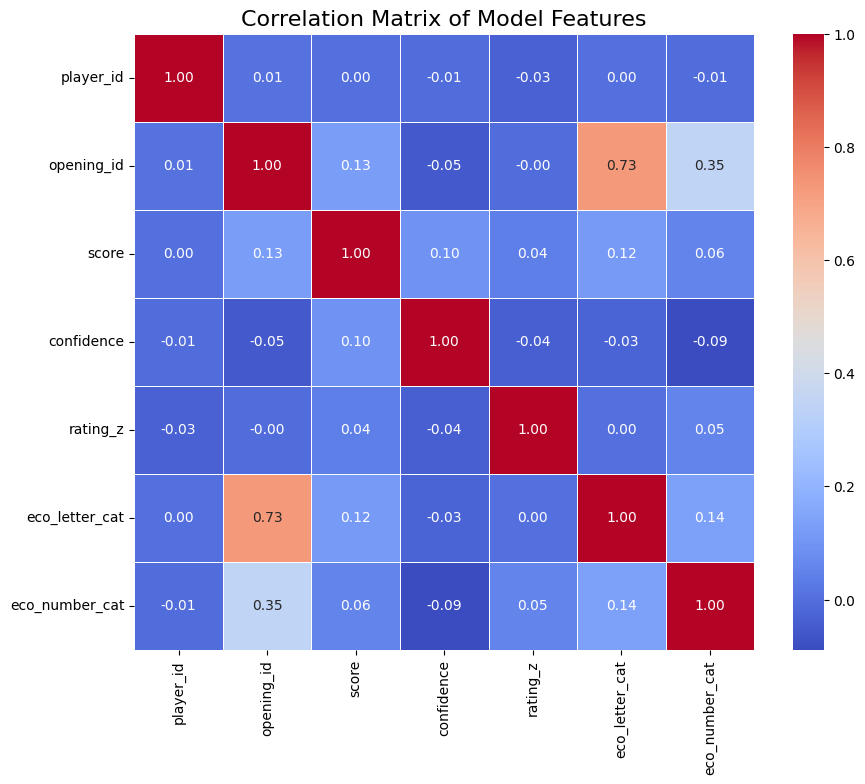


CORRELATIONS WITH TARGET VARIABLE (score)
opening_id        0.125458
eco_letter_cat    0.116776
confidence        0.098085
eco_number_cat    0.055425
rating_z          0.042969
player_id         0.002435

✅ CORRELATION ANALYSIS COMPLETE


In [ ]:
# Step 4c: Correlation Analysis of Processed Data

%pip install seaborn --quiet
import seaborn as sns
import matplotlib.pyplot as plt

print("=" * 60)
print("STEP 4C: CORRELATION ANALYSIS OF PROCESSED DATA")
print("=" * 60)


# Start with the main interaction data (already has remapped IDs, adjusted score, confidence)
corr_df = clean_data[["player_id", "opening_id", "score", "confidence"]].copy()

# Merge player side information (rating_z)
# player_side_info is indexed by the remapped player_id
corr_df = corr_df.merge(
    player_side_info[["rating_z"]], left_on="player_id", right_index=True, how="left"
)

# Merge opening side information (eco categories)
# opening_side_info is indexed by the remapped opening_id
corr_df = corr_df.merge(
    opening_side_info[["eco_letter_cat", "eco_number_cat"]],
    left_on="opening_id",
    right_index=True,
    how="left",
)

print(f"Final DataFrame for correlation created.")
print(f"   • Columns: {corr_df.columns.tolist()}")


correlation_matrix = corr_df.corr()


# 3. Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Model Features", fontsize=16)
plt.show()

# 4. Analyze correlations with the target variable 'score'
print("CORRELATIONS WITH TARGET VARIABLE (score)")
print("=" * 80)
score_correlations = (
    correlation_matrix["score"].drop("score").sort_values(ascending=False)
)
print(score_correlations.to_string())


In [15]:
# Verification: Sample 100 player-opening pairs with reconstructed ECO codes and opening names
# Doing this to make sure that our ECO encoding/decoding is correct

print("=" * 100)
print("VERIFICATION: ECO RECONSTRUCTION AND OPENING NAMES")
print("=" * 100)

# Sample 100 random player-opening pairs from training data
sample_size = 100
sample_data = X_train.sample(min(sample_size, len(X_train)), random_state=42)

print(f"\nSampling {len(sample_data)} player-opening pairs for verification...\n")

# Get unique opening IDs from sample (these are NEW remapped IDs)
new_opening_ids = sample_data['opening_id'].unique()

# Convert NEW opening IDs back to OLD database IDs for query
if opening_remapped:
    old_opening_ids = [opening_idx_to_id[int(new_id)] for new_id in new_opening_ids]
    print(f"   • Converting {len(new_opening_ids)} NEW opening IDs to OLD database IDs for query")
    print(f"   • Example: NEW ID {new_opening_ids[0]} → OLD ID {old_opening_ids[0]}")
else:
    old_opening_ids = new_opening_ids
    print(f"   • No remapping was done - using opening IDs directly")

opening_ids_str = ','.join(map(str, old_opening_ids))

# Query database for opening names using OLD IDs
con = get_db_connection(str(DB_PATH))
try:
    opening_query = f"""
        SELECT id, name, eco
        FROM opening
        WHERE id IN ({opening_ids_str})
    """
    opening_names = pd.DataFrame(con.execute(opening_query).df()).set_index('id')
finally:
    con.close()

print(f"   ✓ Retrieved {len(opening_names)} opening names from database\n")

# Create reverse mappings for ECO decoding
eco_int_to_letter = {v: k for k, v in eco_letter_map.items()}
eco_int_to_number = {v: k for k, v in eco_number_map.items()}

# Build verification table
print(f"{'#':<4} {'Player':<8} {'Opening':<9} {'ECO (DB)':<10} {'Reconstructed':<13} {'Match':<6} {'Opening Name':<50}")
print("=" * 100)

matches = 0
for i, (idx, row) in enumerate(sample_data.iterrows(), 1):
    player_id = int(row['player_id'])
    new_opening_id = int(row['opening_id'])
    
    # Convert NEW opening ID to OLD database ID for lookup
    if opening_remapped:
        old_opening_id = opening_idx_to_id[new_opening_id]
    else:
        old_opening_id = new_opening_id
    
    # Lookup opening side info using NEW ID
    opening_info = opening_side_info.loc[new_opening_id]
    
    # Reconstruct ECO from encoded categorical values
    eco_letter_encoded = opening_info['eco_letter_cat']
    eco_number_encoded = opening_info['eco_number_cat']
    
    eco_letter_decoded = eco_int_to_letter[eco_letter_encoded]
    eco_number_decoded = eco_int_to_number[eco_number_encoded]
    
    reconstructed_eco = f"{eco_letter_decoded}{eco_number_decoded}"
    
    # Get original ECO from database using OLD ID
    db_eco = opening_names.loc[old_opening_id, 'eco']
    opening_name = opening_names.loc[old_opening_id, 'name']
    
    # Check if they match
    match = "✓" if reconstructed_eco == db_eco else "✗"
    if reconstructed_eco == db_eco:
        matches += 1
    
    # Truncate opening name if too long
    if len(opening_name) > 48:
        opening_name = opening_name[:45] + "..."
    
    # Display using NEW opening ID (what's in the data now)
    print(f"{i:<4} {player_id:<8} {new_opening_id:<9} {db_eco:<10} {reconstructed_eco:<13} {match:<6} {opening_name:<50}")

print("=" * 100)
print(f"\n✅ Verification Results:")
print(f"   • Total samples: {len(sample_data)}")
print(f"   • Matches: {matches}/{len(sample_data)} ({100*matches/len(sample_data):.1f}%)")
print(f"   • Mismatches: {len(sample_data) - matches}")

if matches == len(sample_data):
    print(f"\n🎉 Perfect! All ECO codes reconstructed correctly!")
    print(f"   • ID remapping preserved all ECO code mappings")
else:
    print(f"\n⚠️  Warning: Some ECO codes did not match. Investigate mismatches above.")

VERIFICATION: ECO RECONSTRUCTION AND OPENING NAMES

Sampling 100 player-opening pairs for verification...

   • Converting 86 NEW opening IDs to OLD database IDs for query
   • Example: NEW ID 862 → OLD ID 1104
   ✓ Retrieved 86 opening names from database

#    Player   Opening   ECO (DB)   Reconstructed Match  Opening Name                                      
1    24448    862       B28        B28           ✓      Sicilian Defense: O'Kelly Variation, Normal S...  
2    2363     1528      C44        C44           ✓      Scotch Game: Scotch Gambit, Dubois Réti Defense   
3    38165    2153      D86        D86           ✓      Grünfeld Defense: Exchange Variation, Classic...  
4    8697     1899      D07        D07           ✓      Queen's Gambit Declined: Chigorin Defense, Ex...  
5    704      1743      C70        C70           ✓      Ruy Lopez: Morphy Defense, Caro Variation         
6    45947    726       B12        B12           ✓      Caro-Kann Defense: Advance Variation        

## 5. Data Verification and Examination
We're almost there. Let's examine our data structures to check for any obvious flaws.

In [16]:


print("X_train \n", X_train.head())
print("="*60)
print("X_val \n", X_val.head())
print("=" * 60)
print("X_test \n", X_test.head())
print("=" * 60)
print("y_train \n", y_train.head())
print("=" * 60)
print("y_val \n", y_val.head())
print("=" * 60) 
print("y_test \n", y_test.head())

# Now side information
print("player_side_info \n", player_side_info.head())
print("=" * 60)
print("opening_side_info \n", opening_side_info.head())

X_train 
          player_id  opening_id  confidence
130071        2125         653    0.456522
2459660      40362         578    0.206349
725099       11754         501    0.462366
1426531      23420         653    0.484536
899254       14629         198    0.342105
X_val 
          player_id  opening_id  confidence
1841273      30178         962    0.748744
169628        2766         333    0.285714
1916321      31399        2447    0.295775
1620906      26570        1074    0.425287
452506        7342        2460    0.333333
X_test 
          player_id  opening_id  confidence
241950        3931         825    0.242424
322549        5259        1074    0.324324
1447696      23755        1952    0.404762
1445711      23721        1602    0.206349
1624170      26626         561    0.295775
y_train 
 130071     0.483502
2459660    0.531574
725099     0.503618
1426531    0.443116
899254     0.497497
Name: score, dtype: float64
y_val 
 1841273    0.481139
169628     0.527952
1916321    0.

In [17]:
# Final verification: Display cleaned side info tables

print("=" * 60)
print("CLEANED SIDE INFORMATION TABLES")
print("=" * 60)

print(f"\n📊 player_side_info (cleaned):")
print(f"   • Shape: {player_side_info.shape}")
print(f"   • Columns: {list(player_side_info.columns)}")
print(f"   • Index: player_id")
print(f"\n   Sample (5 rows):")
print(player_side_info.head().to_string())

print(f"\n📊 opening_side_info (cleaned):")
print(f"   • Shape: {opening_side_info.shape}")
print(f"   • Columns: {list(opening_side_info.columns)}")
print(f"   • Index: opening_id")
print(f"\n   Sample (5 rows):")
print(opening_side_info.head().to_string())

print(f"\n✅ Both side info tables contain ONLY the necessary model inputs:")
print(f"   • player_side_info: rating_z (normalized rating)")
print(f"   • opening_side_info: eco_letter_cat, eco_number_cat (categorical encodings)")
print(f"   • No unnecessary columns (names, titles, raw strings, etc.)")

CLEANED SIDE INFORMATION TABLES

📊 player_side_info (cleaned):
   • Shape: (48468, 1)
   • Columns: ['rating_z']
   • Index: player_id

   Sample (5 rows):
           rating_z
player_id          
0          0.609707
1          1.059306
2          0.561535
3          0.617735
4         -2.168176

📊 opening_side_info (cleaned):
   • Shape: (2715, 2)
   • Columns: ['eco_letter_cat', 'eco_number_cat']
   • Index: opening_id

   Sample (5 rows):
            eco_letter_cat  eco_number_cat
opening_id                                
531                      1               0
565                      1               0
572                      1               0
579                      1               1
589                      1               1

✅ Both side info tables contain ONLY the necessary model inputs:
   • player_side_info: rating_z (normalized rating)
   • opening_side_info: eco_letter_cat, eco_number_cat (categorical encodings)
   • No unnecessary columns (names, titles, raw strings, 

## Step 5: Convert to PyTorch Tensors

**What are tensors?**
Tensors are PyTorch's version of arrays - just multi-dimensional data structures optimized for deep learning. Think of them like fancy NumPy arrays that can run on GPUs.

**What we need to convert:**

1. **Main features** (X_train, X_val, X_test):
   - `player_id` → long tensor (integer IDs)
   - `opening_id` → long tensor (integer IDs)
   - `confidence` → float tensor (weights for loss function)

2. **Targets** (y_train, y_val, y_test):
   - `score` → float tensor (what we're predicting)

3. **Player side info** (player_side_info):
   - `rating_z` → float tensor (normalized ratings)
   - Indexed by player_id for fast lookup

4. **Opening side info** (opening_side_info):
   - `eco_letter_cat` → long tensor (categorical)
   - `eco_number_cat` → long tensor (categorical)
   - Indexed by opening_id for fast lookup

**Why these data types?**
- `long` (int64): For IDs and categorical features that will be embedded
- `float` (float32): For continuous values like scores, confidence, and normalized ratings



In [18]:
# Install PyTorch (if not already installed)
import sys
import subprocess
import torch


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/a/Documents/personalprojects/chess-opening-recommender/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/a/Documents/personalprojects/chess-opening-recommender/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/a/Documents/personalprojects/chess-opening-

In [19]:
# Step 5: Convert all data to PyTorch tensors

import torch

print("=" * 60)
print("STEP 5: CONVERT TO PYTORCH TENSORS")
print("=" * 60)

# Set random seed for reproducibility
torch.manual_seed(42)

print(f"\n⚙️  Configuration:")
print(f"   • PyTorch version: {torch.__version__}")
print(f"   • CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   • CUDA device: {torch.cuda.get_device_name(0)}")
print(f"   • Default dtype: float32 for continuous, int64 for IDs/categorical")

# 0. Index alignment sanity checks
print(f"\n0️⃣  Index alignment sanity checks...")

# Check player_side_info is properly indexed
print(f"   Checking player_side_info index alignment...")
player_ids_sorted = sorted(player_side_info.index.values)
if player_ids_sorted != list(player_side_info.index.values):
    print(f"   ⚠️  player_side_info index is not sorted - this is OK, we'll use index values directly")
else:
    print(f"   ✓ player_side_info index is sorted")
print(f"   • Index range: [{player_side_info.index.min()}, {player_side_info.index.max()}]")
print(f"   • Index dtype: {player_side_info.index.dtype}")

# Check opening_side_info is properly indexed
print(f"\n   Checking opening_side_info index alignment...")
opening_ids_sorted = sorted(opening_side_info.index.values)
if opening_ids_sorted != list(opening_side_info.index.values):
    print(f"   ⚠️  opening_side_info index is not sorted - this is OK, we'll use index values directly")
else:
    print(f"   ✓ opening_side_info index is sorted")
print(f"   • Index range: [{opening_side_info.index.min()}, {opening_side_info.index.max()}]")
print(f"   • Index dtype: {opening_side_info.index.dtype}")

# CRITICAL: Check if indices are contiguous 0-based
# If opening_side_info.index = [0, 1, 2, ..., N-1], then we can use opening_id as direct array index
# If not (e.g., [10, 15, 23, ...]), we'll need a mapping dictionary
print(f"\n   Checking if indices are contiguous 0-based...")
player_contiguous = (player_side_info.index == range(len(player_side_info))).all()
opening_contiguous = (opening_side_info.index == range(len(opening_side_info))).all()

print(f"   • player_side_info contiguous 0-based: {player_contiguous}")
print(f"   • opening_side_info contiguous 0-based: {opening_contiguous}")

if not player_contiguous:
    print(f"   ℹ️  Player IDs are NOT 0-based contiguous - will need mapping for embedding lookup")
if not opening_contiguous:
    print(f"   ℹ️  Opening IDs are NOT 0-based contiguous - will need mapping for embedding lookup")

# 1. Convert main features (train/val/test)
print(f"\n1️⃣  Converting main features (X_train, X_val, X_test)...")

# Train set
player_ids_train = torch.tensor(X_train['player_id'].values, dtype=torch.long)
opening_ids_train = torch.tensor(X_train['opening_id'].values, dtype=torch.long)
confidence_train = torch.tensor(X_train['confidence'].values, dtype=torch.float32)

print(f"   Train tensors:")
print(f"   • player_ids_train: {player_ids_train.shape}, dtype={player_ids_train.dtype}")
print(f"   • opening_ids_train: {opening_ids_train.shape}, dtype={opening_ids_train.dtype}")
print(f"   • confidence_train: {confidence_train.shape}, dtype={confidence_train.dtype}")

# Validation set
player_ids_val = torch.tensor(X_val['player_id'].values, dtype=torch.long)
opening_ids_val = torch.tensor(X_val['opening_id'].values, dtype=torch.long)
confidence_val = torch.tensor(X_val['confidence'].values, dtype=torch.float32)

print(f"\n   Validation tensors:")
print(f"   • player_ids_val: {player_ids_val.shape}, dtype={player_ids_val.dtype}")
print(f"   • opening_ids_val: {opening_ids_val.shape}, dtype={opening_ids_val.dtype}")
print(f"   • confidence_val: {confidence_val.shape}, dtype={confidence_val.dtype}")

# Test set
player_ids_test = torch.tensor(X_test['player_id'].values, dtype=torch.long)
opening_ids_test = torch.tensor(X_test['opening_id'].values, dtype=torch.long)
confidence_test = torch.tensor(X_test['confidence'].values, dtype=torch.float32)

print(f"\n   Test tensors:")
print(f"   • player_ids_test: {player_ids_test.shape}, dtype={player_ids_test.dtype}")
print(f"   • opening_ids_test: {opening_ids_test.shape}, dtype={opening_ids_test.dtype}")
print(f"   • confidence_test: {confidence_test.shape}, dtype={confidence_test.dtype}")

# 2. Convert targets (scores)
print(f"\n2️⃣  Converting target scores (y_train, y_val, y_test)...")

scores_train = torch.tensor(y_train.values, dtype=torch.float32)
scores_val = torch.tensor(y_val.values, dtype=torch.float32)
scores_test = torch.tensor(y_test.values, dtype=torch.float32)

print(f"   • scores_train: {scores_train.shape}, dtype={scores_train.dtype}")
print(f"   • scores_val: {scores_val.shape}, dtype={scores_val.dtype}")
print(f"   • scores_test: {scores_test.shape}, dtype={scores_test.dtype}")

print(f"\n   Score ranges (sanity check):")
print(f"   • Train: [{scores_train.min():.4f}, {scores_train.max():.4f}]")
print(f"   • Val: [{scores_val.min():.4f}, {scores_val.max():.4f}]")
print(f"   • Test: [{scores_test.min():.4f}, {scores_test.max():.4f}]")

# 3. Convert player side information
print(f"\n3️⃣  Converting player side information...")

# Create tensor of all player ratings (indexed by player_id)
# Since player_side_info is indexed by player_id, we need to ensure coverage
player_ratings_tensor = torch.tensor(player_side_info['rating_z'].values, dtype=torch.float32)
player_ids_in_side_info = torch.tensor(player_side_info.index.values, dtype=torch.long)

print(f"   • player_ratings_tensor: {player_ratings_tensor.shape}, dtype={player_ratings_tensor.dtype}")
print(f"   • player_ids_in_side_info: {player_ids_in_side_info.shape}, dtype={player_ids_in_side_info.dtype}")
print(f"   • Rating range: [{player_ratings_tensor.min():.4f}, {player_ratings_tensor.max():.4f}]")

# Verify all player IDs in train/val/test are covered
all_player_ids = torch.cat([player_ids_train, player_ids_val, player_ids_test]).unique()
missing_players = set(all_player_ids.tolist()) - set(player_ids_in_side_info.tolist())
if len(missing_players) > 0:
    print(f"   ⚠️  WARNING: {len(missing_players)} players in splits missing from side_info!")
else:
    print(f"   ✓ All {len(all_player_ids)} unique players in splits have side information")

# 4. Convert opening side information
print(f"\n4️⃣  Converting opening side information...")

# Verify column names exist (using eco_letter_cat and eco_number_cat consistently)
if 'eco_letter_cat' not in opening_side_info.columns:
    raise ValueError(f"Column 'eco_letter_cat' not found. Available: {opening_side_info.columns.tolist()}")
if 'eco_number_cat' not in opening_side_info.columns:
    raise ValueError(f"Column 'eco_number_cat' not found. Available: {opening_side_info.columns.tolist()}")

# Create tensors for opening ECO features (indexed by opening_id)
opening_eco_letter_tensor = torch.tensor(opening_side_info['eco_letter_cat'].values, dtype=torch.long)
opening_eco_number_tensor = torch.tensor(opening_side_info['eco_number_cat'].values, dtype=torch.long)
opening_ids_in_side_info = torch.tensor(opening_side_info.index.values, dtype=torch.long)

print(f"   • opening_eco_letter_tensor: {opening_eco_letter_tensor.shape}, dtype={opening_eco_letter_tensor.dtype}")
print(f"   • opening_eco_number_tensor: {opening_eco_number_tensor.shape}, dtype={opening_eco_number_tensor.dtype}")
print(f"   • opening_ids_in_side_info: {opening_ids_in_side_info.shape}, dtype={opening_ids_in_side_info.dtype}")
print(f"   • ECO letter range: [{opening_eco_letter_tensor.min()}, {opening_eco_letter_tensor.max()}]")
print(f"   • ECO number range: [{opening_eco_number_tensor.min()}, {opening_eco_number_tensor.max()}]")

# Verify all opening IDs in train/val/test are covered
all_opening_ids = torch.cat([opening_ids_train, opening_ids_val, opening_ids_test]).unique()
missing_openings = set(all_opening_ids.tolist()) - set(opening_ids_in_side_info.tolist())
if len(missing_openings) > 0:
    print(f"   ⚠️  WARNING: {len(missing_openings)} openings in splits missing from side_info!")
else:
    print(f"   ✓ All {len(all_opening_ids)} unique openings in splits have side information")

# 5. Summary statistics
print(f"\n5️⃣  Summary statistics:")
print(f"\n   Dataset sizes:")
print(f"   • Train: {len(scores_train):,} samples")
print(f"   • Val: {len(scores_val):,} samples")
print(f"   • Test: {len(scores_test):,} samples")

print(f"\n   Unique entities:")
print(f"   • Players: {len(player_ids_in_side_info):,}")
print(f"   • Openings: {len(opening_ids_in_side_info):,}")

print(f"\n   Vocabulary sizes (for embedding layers):")
print(f"   • num_players: {player_ids_in_side_info.max() + 1} (max player_id + 1)")
print(f"   • num_openings: {opening_ids_in_side_info.max() + 1} (max opening_id + 1)")
print(f"   • num_eco_letters: {opening_eco_letter_tensor.max() + 1} (max eco_letter_cat + 1)")
print(f"   • num_eco_numbers: {opening_eco_number_tensor.max() + 1} (max eco_number_cat + 1)")

# 6. Memory usage (approximate - using simple calculation)
print(f"\n6️⃣  Approximate memory usage:")
# More efficient calculation: element_size * nelement for each tensor
# Using list comprehension with helper function for cleaner code
def tensor_memory_mb(t):
    """Calculate tensor memory in MB"""
    return (t.element_size() * t.nelement()) / (1024 * 1024)

tensors = [
    player_ids_train, opening_ids_train, confidence_train, scores_train,
    player_ids_val, opening_ids_val, confidence_val, scores_val,
    player_ids_test, opening_ids_test, confidence_test, scores_test,
    player_ratings_tensor, opening_eco_letter_tensor, opening_eco_number_tensor
]
total_memory_mb = sum(tensor_memory_mb(t) for t in tensors)
print(f"   • Total tensor memory: {total_memory_mb:.2f} MB")

print("\n" + "=" * 60)
print("✅ TENSOR CONVERSION COMPLETE")
print("=" * 60)

print(f"\n📦 Available tensors for training:")
print(f"\n   Main features (train/val/test):")
print(f"   • player_ids_train, player_ids_val, player_ids_test")
print(f"   • opening_ids_train, opening_ids_val, opening_ids_test")
print(f"   • confidence_train, confidence_val, confidence_test")

print(f"\n   Targets (train/val/test):")
print(f"   • scores_train, scores_val, scores_test")

print(f"\n   Side information:")
print(f"   • player_ratings_tensor (indexed by player_ids_in_side_info)")
print(f"   • opening_eco_letter_tensor (indexed by opening_ids_in_side_info)")
print(f"   • opening_eco_number_tensor (indexed by opening_ids_in_side_info)")

print(f"\n💡 Ready for model training!")
print(f"   These tensors can be directly fed into PyTorch DataLoaders and models.")

STEP 5: CONVERT TO PYTORCH TENSORS

⚙️  Configuration:
   • PyTorch version: 2.2.2
   • CUDA available: False
   • Default dtype: float32 for continuous, int64 for IDs/categorical

0️⃣  Index alignment sanity checks...
   Checking player_side_info index alignment...
   ✓ player_side_info index is sorted
   • Index range: [0, 48467]
   • Index dtype: int64

   Checking opening_side_info index alignment...
   ⚠️  opening_side_info index is not sorted - this is OK, we'll use index values directly
   • Index range: [0, 2714]
   • Index dtype: int64

   Checking if indices are contiguous 0-based...
   • player_side_info contiguous 0-based: True
   • opening_side_info contiguous 0-based: False
   ℹ️  Opening IDs are NOT 0-based contiguous - will need mapping for embedding lookup

1️⃣  Converting main features (X_train, X_val, X_test)...
   Train tensors:
   • player_ids_train: torch.Size([2172843]), dtype=torch.int64
   • opening_ids_train: torch.Size([2172843]), dtype=torch.int64
   • confi

## Step 6: Training Setup

Define all constants, loss functions, optimizer, and helper functions for training.

**What we need to set up:**

1. **Constants and Hyperparameters:**
   - `NUM_FACTORS`: Dimensionality of latent factor embeddings (e.g., 50)
   - `LEARNING_RATE`: Step size for SGD optimizer (e.g., 0.01)
   - `BATCH_SIZE`: Number of samples per training batch (e.g., 1024)
   - `N_EPOCHS`: Number of full passes through training data (e.g., 10)
   - Random seeds for reproducibility

2. **Loss Functions:**
   - MSE (Mean Squared Error): Main training loss
   - RMSE (Root Mean Squared Error): Evaluation metric
   - Confidence-weighted loss: Down-weight uncertain predictions

3. **Optimizer:**
   - SGD (Stochastic Gradient Descent) with momentum

4. **Helper Functions:**
   - `train_one_epoch()`: Train for one epoch
   - `evaluate_model()`: Evaluate on validation/test set
   - `calculate_rmse()`: Compute RMSE metric
   - `save_checkpoint()`: Save model state

5. **Logging:**
   - Progress bars with ETA
   - Loss tracking per epoch
   - Model checkpointing


In [20]:
# Step 6a: Define Hyperparameters and Constants

import torch
import random
import numpy as np

print("=" * 60)
print("STEP 6A: DEFINE HYPERPARAMETERS AND CONSTANTS")
print("=" * 60)

# ========================================
# HYPERPARAMETERS (Easy to modify here)
# ========================================

# Model architecture
NUM_FACTORS = 50  # Dimensionality of latent factor embeddings

# Training parameters
LEARNING_RATE = 0.01  # SGD learning rate
MOMENTUM = 0.9  # SGD momentum
BATCH_SIZE = 1024  # Mini-batch size
N_EPOCHS = 20  # Number of training epochs

# Regularization (if needed)
WEIGHT_DECAY = 0.0  # L2 regularization (0 = no regularization)

# Random seeds for reproducibility
RANDOM_SEED = 42

# Device configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model saving configuration
MODEL_SAVE_DIR = Path.cwd().parent / "data" / "models"  # Saves to root/data/models
MODEL_SAVE_DIR.mkdir(parents=True, exist_ok=True)


print(f"\n📋 Hyperparameters:")
print(f"   • NUM_FACTORS: {NUM_FACTORS}")
print(f"   • LEARNING_RATE: {LEARNING_RATE}")
print(f"   • MOMENTUM: {MOMENTUM}")
print(f"   • BATCH_SIZE: {BATCH_SIZE}")
print(f"   • N_EPOCHS: {N_EPOCHS}")
print(f"   • WEIGHT_DECAY: {WEIGHT_DECAY}")

print(f"\n🎲 Random Seed:")
print(f"   • RANDOM_SEED: {RANDOM_SEED}")

print(f"\n💻 Device Configuration:")
print(f"   • DEVICE: {DEVICE}")
if torch.cuda.is_available():
    print(f"   • GPU: {torch.cuda.get_device_name(0)}")
    print(f"   • GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print(f"\n💾 Model Saving:")
print(f"   • Save directory: {MODEL_SAVE_DIR}")

# ========================================
# SET RANDOM SEEDS FOR REPRODUCIBILITY
# ========================================

print(f"\n🔒 Setting random seeds for reproducibility...")

# Python random
random.seed(RANDOM_SEED)
print(f"   ✓ Python random seed set to {RANDOM_SEED}")

# NumPy random
np.random.seed(RANDOM_SEED)
print(f"   ✓ NumPy random seed set to {RANDOM_SEED}")

# PyTorch random
torch.manual_seed(RANDOM_SEED)
print(f"   ✓ PyTorch CPU random seed set to {RANDOM_SEED}")

if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)  # For multi-GPU
    print(f"   ✓ PyTorch GPU random seed set to {RANDOM_SEED}")
    
    # Additional CUDA reproducibility settings
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"   ✓ CUDA deterministic mode enabled")

# ========================================
# CALCULATE VOCABULARY SIZES
# ========================================

print(f"\n📊 Vocabulary Sizes (for embedding layers):")

# Calculate from our tensors
NUM_PLAYERS = int(player_ids_in_side_info.max()) + 1
NUM_OPENINGS = int(opening_ids_in_side_info.max()) + 1
NUM_ECO_LETTERS = int(opening_eco_letter_tensor.max()) + 1
NUM_ECO_NUMBERS = int(opening_eco_number_tensor.max()) + 1

print(f"   • NUM_PLAYERS: {NUM_PLAYERS:,} (max player_id + 1)")
print(f"   • NUM_OPENINGS: {NUM_OPENINGS:,} (max opening_id + 1)")
print(f"   • NUM_ECO_LETTERS: {NUM_ECO_LETTERS} (ECO letter categories)")
print(f"   • NUM_ECO_NUMBERS: {NUM_ECO_NUMBERS} (ECO number categories)")

# ========================================
# DATASET STATISTICS
# ========================================

print(f"\n📈 Dataset Statistics:")
print(f"   • Train samples: {len(scores_train):,}")
print(f"   • Validation samples: {len(scores_val):,}")
print(f"   • Test samples: {len(scores_test):,}")
print(f"   • Total samples: {len(scores_train) + len(scores_val) + len(scores_test):,}")

print(f"\n   • Batches per epoch: {len(scores_train) // BATCH_SIZE:,}")
print(f"   • Training iterations (total): {(len(scores_train) // BATCH_SIZE) * N_EPOCHS:,}")

print("\n" + "=" * 60)
print("✅ HYPERPARAMETERS AND CONSTANTS DEFINED")
print("=" * 60)

print(f"\n💡 To modify hyperparameters:")
print(f"   • Edit the values at the top of this cell")
print(f"   • Rerun this cell to apply changes")
print(f"   • All subsequent cells will use the updated values")


STEP 6A: DEFINE HYPERPARAMETERS AND CONSTANTS

📋 Hyperparameters:
   • NUM_FACTORS: 50
   • LEARNING_RATE: 0.01
   • MOMENTUM: 0.9
   • BATCH_SIZE: 1024
   • N_EPOCHS: 20
   • WEIGHT_DECAY: 0.0

🎲 Random Seed:
   • RANDOM_SEED: 42

💻 Device Configuration:
   • DEVICE: cpu

💾 Model Saving:
   • Save directory: /Users/a/Documents/personalprojects/chess-opening-recommender/data/models

🔒 Setting random seeds for reproducibility...
   ✓ Python random seed set to 42
   ✓ NumPy random seed set to 42
   ✓ PyTorch CPU random seed set to 42

📊 Vocabulary Sizes (for embedding layers):
   • NUM_PLAYERS: 48,468 (max player_id + 1)
   • NUM_OPENINGS: 2,715 (max opening_id + 1)
   • NUM_ECO_LETTERS: 5 (ECO letter categories)
   • NUM_ECO_NUMBERS: 100 (ECO number categories)

📈 Dataset Statistics:
   • Train samples: 2,172,843
   • Validation samples: 434,569
   • Test samples: 289,713
   • Total samples: 2,897,125

   • Batches per epoch: 2,121
   • Training iterations (total): 42,420

✅ HYPERPARAME

In [21]:
# Step 6b: Define Loss Functions

import torch.nn as nn
import torch.nn.functional as F

print("=" * 60)
print("STEP 6B: DEFINE LOSS FUNCTIONS")
print("=" * 60)

# ========================================
# LOSS FUNCTIONS
# ========================================

def mse_loss(predictions, targets, confidence_weights=None):
    """
    Mean Squared Error loss with optional confidence weighting.
    
    Parameters:
    -----------
    predictions : torch.Tensor
        Model predictions (shape: [batch_size])
    targets : torch.Tensor
        Ground truth scores (shape: [batch_size])
    confidence_weights : torch.Tensor, optional
        Confidence weights for each sample (shape: [batch_size])
        Higher confidence = larger loss contribution
        
    Returns:
    --------
    torch.Tensor
        Scalar loss value
    """
    # Compute squared error
    squared_error = (predictions - targets) ** 2
    
    # Apply confidence weighting if provided
    if confidence_weights is not None:
        weighted_squared_error = squared_error * confidence_weights
        # Average over all samples (sum of weighted errors / sum of weights)
        loss = weighted_squared_error.sum() / confidence_weights.sum()
    else:
        # Standard MSE (average over all samples)
        loss = squared_error.mean()
    
    return loss


def rmse_loss(predictions, targets, confidence_weights=None):
    """
    Root Mean Squared Error loss.
    
    This is the square root of MSE and is our primary evaluation metric.
    RMSE is in the same units as the target (score), making it interpretable.
    
    Parameters:
    -----------
    predictions : torch.Tensor
        Model predictions (shape: [batch_size])
    targets : torch.Tensor
        Ground truth scores (shape: [batch_size])
    confidence_weights : torch.Tensor, optional
        Confidence weights for each sample (shape: [batch_size])
        
    Returns:
    --------
    torch.Tensor
        Scalar RMSE value
    """
    mse = mse_loss(predictions, targets, confidence_weights)
    return torch.sqrt(mse)


def calculate_rmse(predictions, targets, confidence_weights=None):
    """
    Calculate RMSE metric (convenience function for evaluation).
    
    This is the same as rmse_loss but with clearer naming for evaluation.
    
    Parameters:
    -----------
    predictions : torch.Tensor
        Model predictions (shape: [batch_size])
    targets : torch.Tensor
        Ground truth scores (shape: [batch_size])
    confidence_weights : torch.Tensor, optional
        Confidence weights for each sample (shape: [batch_size])
        
    Returns:
    --------
    float
        RMSE value (Python float, not tensor)
    """
    with torch.no_grad():  # Don't compute gradients for evaluation
        rmse = rmse_loss(predictions, targets, confidence_weights)
    return rmse.item()


# ========================================
# TEST LOSS FUNCTIONS
# ========================================

print(f"\n✅ Loss functions defined:")
print(f"   • mse_loss(): Mean Squared Error (with optional confidence weighting)")
print(f"   • rmse_loss(): Root Mean Squared Error")
print(f"   • calculate_rmse(): RMSE evaluation metric")

print(f"\n🧪 Testing loss functions with dummy data...")

# Create dummy data for testing
dummy_predictions = torch.tensor([0.5, 0.6, 0.7, 0.8], dtype=torch.float32)
dummy_targets = torch.tensor([0.55, 0.62, 0.68, 0.75], dtype=torch.float32)
dummy_confidence = torch.tensor([0.8, 0.9, 0.7, 1.0], dtype=torch.float32)

print(f"\n   Dummy data:")
print(f"   • Predictions: {dummy_predictions.tolist()}")
print(f"   • Targets: {dummy_targets.tolist()}")
print(f"   • Confidence: {dummy_confidence.tolist()}")

# Test MSE without confidence weighting
mse_unweighted = mse_loss(dummy_predictions, dummy_targets)
print(f"\n   MSE (unweighted): {mse_unweighted.item():.6f}")

# Test MSE with confidence weighting
mse_weighted = mse_loss(dummy_predictions, dummy_targets, dummy_confidence)
print(f"   MSE (weighted): {mse_weighted.item():.6f}")

# Test RMSE
rmse_unweighted = rmse_loss(dummy_predictions, dummy_targets)
rmse_weighted = rmse_loss(dummy_predictions, dummy_targets, dummy_confidence)
print(f"\n   RMSE (unweighted): {rmse_unweighted.item():.6f}")
print(f"   RMSE (weighted): {rmse_weighted.item():.6f}")

# Test calculate_rmse
rmse_eval = calculate_rmse(dummy_predictions, dummy_targets, dummy_confidence)
print(f"\n   calculate_rmse() result: {rmse_eval:.6f}")
print(f"   ✓ Returns Python float (not tensor): {type(rmse_eval)}")

print("\n" + "=" * 60)
print("✅ LOSS FUNCTIONS COMPLETE")
print("=" * 60)

print(f"\n💡 Training will use:")
print(f"   • Loss function: mse_loss() with confidence weighting")
print(f"   • Evaluation metric: calculate_rmse()")
print(f"   • Confidence weights: From 'confidence' column in data")
print(f"   • Weighting strategy: confidence = num_games / (num_games + K)")
print(f"   • Effect: High-game-count entries have larger loss impact")


STEP 6B: DEFINE LOSS FUNCTIONS

✅ Loss functions defined:
   • mse_loss(): Mean Squared Error (with optional confidence weighting)
   • rmse_loss(): Root Mean Squared Error
   • calculate_rmse(): RMSE evaluation metric

🧪 Testing loss functions with dummy data...

   Dummy data:
   • Predictions: [0.5, 0.6000000238418579, 0.699999988079071, 0.800000011920929]
   • Targets: [0.550000011920929, 0.6200000047683716, 0.6800000071525574, 0.75]
   • Confidence: [0.800000011920929, 0.8999999761581421, 0.699999988079071, 1.0]

   MSE (unweighted): 0.001450
   MSE (weighted): 0.001512

   RMSE (unweighted): 0.038079
   RMSE (weighted): 0.038881

   calculate_rmse() result: 0.038881
   ✓ Returns Python float (not tensor): <class 'float'>

✅ LOSS FUNCTIONS COMPLETE

💡 Training will use:
   • Loss function: mse_loss() with confidence weighting
   • Evaluation metric: calculate_rmse()
   • Confidence weights: From 'confidence' column in data
   • Weighting strategy: confidence = num_games / (num_gam

In [22]:
# Step 6c: Create PyTorch Dataset and DataLoader

from torch.utils.data import Dataset, DataLoader

print("=" * 60)
print("STEP 6C: CREATE PYTORCH DATASET AND DATALOADER")
print("=" * 60)

# ========================================
# CUSTOM DATASET CLASS
# ========================================

class ChessOpeningDataset(Dataset):
    """
    PyTorch Dataset for chess player-opening interactions.
    
    Each sample contains:
    - player_id: Integer ID for embedding lookup
    - opening_id: Integer ID for embedding lookup
    - confidence: Confidence weight for loss function
    - score: Target value (win rate)
    """
    
    def __init__(self, player_ids, opening_ids, confidence, scores):
        """
        Initialize dataset.
        
        Parameters:
        -----------
        player_ids : torch.Tensor
            Player IDs (long tensor)
        opening_ids : torch.Tensor
            Opening IDs (long tensor)
        confidence : torch.Tensor
            Confidence weights (float tensor)
        scores : torch.Tensor
            Target scores (float tensor)
        """
        self.player_ids = player_ids
        self.opening_ids = opening_ids
        self.confidence = confidence
        self.scores = scores
        
        # Validate shapes
        assert len(player_ids) == len(opening_ids) == len(confidence) == len(scores), \
            "All tensors must have the same length"
        
    def __len__(self):
        """Return the number of samples."""
        return len(self.player_ids)
    
    def __getitem__(self, idx):
        """
        Get a single sample.
        
        Parameters:
        -----------
        idx : int
            Index of the sample to retrieve
            
        Returns:
        --------
        dict
            Dictionary with keys: 'player_id', 'opening_id', 'confidence', 'score'
        """
        return {
            'player_id': self.player_ids[idx],
            'opening_id': self.opening_ids[idx],
            'confidence': self.confidence[idx],
            'score': self.scores[idx]
        }


# ========================================
# CREATE DATASETS
# ========================================

print(f"\n1️⃣  Creating PyTorch Datasets...")

train_dataset = ChessOpeningDataset(
    player_ids_train, opening_ids_train, confidence_train, scores_train
)
val_dataset = ChessOpeningDataset(
    player_ids_val, opening_ids_val, confidence_val, scores_val
)
test_dataset = ChessOpeningDataset(
    player_ids_test, opening_ids_test, confidence_test, scores_test
)

print(f"   ✓ Train dataset: {len(train_dataset):,} samples")
print(f"   ✓ Validation dataset: {len(val_dataset):,} samples")
print(f"   ✓ Test dataset: {len(test_dataset):,} samples")

# Test dataset access
print(f"\n2️⃣  Testing dataset access...")
sample = train_dataset[0]
print(f"   Sample from train_dataset[0]:")
print(f"   • player_id: {sample['player_id']}")
print(f"   • opening_id: {sample['opening_id']}")
print(f"   • confidence: {sample['confidence']:.4f}")
print(f"   • score: {sample['score']:.4f}")

# ========================================
# CREATE DATALOADERS
# ========================================

print(f"\n3️⃣  Creating PyTorch DataLoaders...")

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle training data each epoch
    num_workers=0,  # Number of subprocesses for data loading (0 = main process)
    pin_memory=True if torch.cuda.is_available() else False  # Speed up GPU transfer
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Don't shuffle validation data
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Don't shuffle test data
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"   ✓ Train loader: {len(train_loader):,} batches of size {BATCH_SIZE}")
print(f"   ✓ Validation loader: {len(val_loader):,} batches of size {BATCH_SIZE}")
print(f"   ✓ Test loader: {len(test_loader):,} batches of size {BATCH_SIZE}")

# Test dataloader
print(f"\n4️⃣  Testing DataLoader batch access...")
batch = next(iter(train_loader))
print(f"   First batch from train_loader:")
print(f"   • player_id shape: {batch['player_id'].shape}")
print(f"   • opening_id shape: {batch['opening_id'].shape}")
print(f"   • confidence shape: {batch['confidence'].shape}")
print(f"   • score shape: {batch['score'].shape}")

print(f"\n   Sample values from first batch (first 5):")
for i in range(min(5, batch['player_id'].shape[0])):
    print(f"   [{i}] player={batch['player_id'][i]}, opening={batch['opening_id'][i]}, "
          f"conf={batch['confidence'][i]:.4f}, score={batch['score'][i]:.4f}")

print("\n" + "=" * 60)
print("✅ DATASET AND DATALOADER COMPLETE")
print("=" * 60)

print(f"\n📦 Available objects:")
print(f"   • train_dataset, val_dataset, test_dataset")
print(f"   • train_loader, val_loader, test_loader")

print(f"\n💡 DataLoader features:")
print(f"   • Automatic batching: {BATCH_SIZE} samples per batch")
print(f"   • Shuffling: Training data shuffled each epoch")
print(f"   • Pin memory: {'Enabled' if torch.cuda.is_available() else 'Disabled'} (speeds up GPU transfer)")
print(f"   • Ready for training loop!")


STEP 6C: CREATE PYTORCH DATASET AND DATALOADER

1️⃣  Creating PyTorch Datasets...
   ✓ Train dataset: 2,172,843 samples
   ✓ Validation dataset: 434,569 samples
   ✓ Test dataset: 289,713 samples

2️⃣  Testing dataset access...
   Sample from train_dataset[0]:
   • player_id: 2125
   • opening_id: 653
   • confidence: 0.4565
   • score: 0.4835

3️⃣  Creating PyTorch DataLoaders...
   ✓ Train loader: 2,122 batches of size 1024
   ✓ Validation loader: 425 batches of size 1024
   ✓ Test loader: 283 batches of size 1024

4️⃣  Testing DataLoader batch access...
   First batch from train_loader:
   • player_id shape: torch.Size([1024])
   • opening_id shape: torch.Size([1024])
   • confidence shape: torch.Size([1024])
   • score shape: torch.Size([1024])

   Sample values from first batch (first 5):
   [0] player=33836, opening=733, conf=0.2308, score=0.4848
   [1] player=21504, opening=2287, conf=0.2308, score=0.5979
   [2] player=22465, opening=1078, conf=0.7807, score=0.4376
   [3] player

In [23]:
# Step 6d: Define Helper Functions for Training

import time
from datetime import timedelta

print("=" * 60)
print("STEP 6D: DEFINE HELPER FUNCTIONS")
print("=" * 60)

# ========================================
# HELPER FUNCTION: Save Checkpoint
# ========================================

def save_checkpoint(model, optimizer, epoch, train_loss, val_loss, filepath):
    """
    Save model checkpoint to disk.
    
    Parameters:
    -----------
    model : nn.Module
        The model to save
    optimizer : torch.optim.Optimizer
        The optimizer state to save
    epoch : int
        Current epoch number
    train_loss : float
        Training loss for this epoch
    val_loss : float
        Validation loss for this epoch
    filepath : Path or str
        Where to save the checkpoint
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        
        # Save hyperparameters for reproducibility
        'hyperparameters': {
            'num_factors': NUM_FACTORS,
            'learning_rate': LEARNING_RATE,
            'momentum': MOMENTUM,
            'batch_size': BATCH_SIZE,
            'num_players': NUM_PLAYERS,
            'num_openings': NUM_OPENINGS,
            'num_eco_letters': NUM_ECO_LETTERS,
            'num_eco_numbers': NUM_ECO_NUMBERS,
        }
    }
    
    torch.save(checkpoint, filepath)
    print(f"   💾 Checkpoint saved to: {filepath}")


# ========================================
# HELPER FUNCTION: Load Checkpoint
# ========================================

def load_checkpoint(model, optimizer, filepath):
    """
    Load model checkpoint from disk.
    
    Parameters:
    -----------
    model : nn.Module
        The model to load weights into
    optimizer : torch.optim.Optimizer
        The optimizer to load state into
    filepath : Path or str
        Where to load the checkpoint from
        
    Returns:
    --------
    int
        The epoch number from the checkpoint
    """
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    
    print(f"   📂 Checkpoint loaded from: {filepath}")
    print(f"   • Epoch: {epoch}")
    print(f"   • Train loss: {checkpoint['train_loss']:.6f}")
    print(f"   • Val loss: {checkpoint['val_loss']:.6f}")
    
    return epoch


# ========================================
# HELPER FUNCTION: Format Time
# ========================================

def format_time(seconds):
    """
    Format seconds as human-readable time string.
    
    Parameters:
    -----------
    seconds : float
        Number of seconds
        
    Returns:
    --------
    str
        Formatted time string (e.g., "1h 23m 45s")
    """
    if seconds < 60:
        return f"{seconds:.1f}s"
    elif seconds < 3600:
        minutes = int(seconds // 60)
        secs = int(seconds % 60)
        return f"{minutes}m {secs}s"
    else:
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        secs = int(seconds % 60)
        return f"{hours}h {minutes}m {secs}s"


# ========================================
# HELPER FUNCTION: Print Progress
# ========================================

def print_progress(epoch, batch_idx, total_batches, loss, elapsed_time):
    """
    Print training progress with ETA.
    
    Parameters:
    -----------
    epoch : int
        Current epoch number
    batch_idx : int
        Current batch index (0-based)
    total_batches : int
        Total number of batches per epoch
    loss : float
        Current loss value
    elapsed_time : float
        Elapsed time in seconds since epoch start
    """
    # Calculate progress
    progress_pct = 100.0 * (batch_idx + 1) / total_batches
    
    # Estimate time remaining
    time_per_batch = elapsed_time / (batch_idx + 1)
    remaining_batches = total_batches - (batch_idx + 1)
    eta_seconds = time_per_batch * remaining_batches
    
    # Print progress bar
    bar_length = 40
    filled_length = int(bar_length * (batch_idx + 1) / total_batches)
    bar = '█' * filled_length + '░' * (bar_length - filled_length)
    
    print(f"   Epoch {epoch} [{bar}] {progress_pct:>6.2f}% | "
          f"Loss: {loss:.6f} | "
          f"ETA: {format_time(eta_seconds)}", end='\r')


# ========================================
# TEST HELPER FUNCTIONS
# ========================================

print(f"\n✅ Helper functions defined:")
print(f"   • save_checkpoint(): Save model and optimizer state")
print(f"   • load_checkpoint(): Load model and optimizer state")
print(f"   • format_time(): Format seconds as readable time")
print(f"   • print_progress(): Print training progress with ETA")

print(f"\n🧪 Testing helper functions...")

# Test format_time
print(f"\n   format_time() tests:")
test_times = [30, 90, 300, 3661, 7384]
for t in test_times:
    print(f"   • {t} seconds → {format_time(t)}")

# Test print_progress (will overwrite line)
print(f"\n   print_progress() test (simulating batch progress):")
for i in range(0, 101, 20):
    total = 100
    loss = 0.05 - i * 0.0003
    elapsed = i * 0.5
    print_progress(epoch=1, batch_idx=i, total_batches=total, loss=loss, elapsed_time=elapsed)
    time.sleep(0.1)  # Brief pause to show animation
print()  # New line after progress bar

print("\n" + "=" * 60)
print("✅ HELPER FUNCTIONS COMPLETE")
print("=" * 60)

print(f"\n💡 These functions will be used during training for:")
print(f"   • Progress tracking with ETA estimation")
print(f"   • Saving checkpoints after each epoch")
print(f"   • Loading checkpoints for resuming training")


STEP 6D: DEFINE HELPER FUNCTIONS

✅ Helper functions defined:
   • save_checkpoint(): Save model and optimizer state
   • load_checkpoint(): Load model and optimizer state
   • format_time(): Format seconds as readable time
   • print_progress(): Print training progress with ETA

🧪 Testing helper functions...

   format_time() tests:
   • 30 seconds → 30.0s
   • 90 seconds → 1m 30s
   • 300 seconds → 5m 0s
   • 3661 seconds → 1h 1m 1s
   • 7384 seconds → 2h 3m 4s

   print_progress() test (simulating batch progress):
   Epoch 1 [████████████████████████████████████████] 101.00% | Loss: 0.020000 | ETA: -0.5s

✅ HELPER FUNCTIONS COMPLETE

💡 These functions will be used during training for:
   • Progress tracking with ETA estimation
   • Saving checkpoints after each epoch
   • Loading checkpoints for resuming training
   Epoch 1 [████████████████████████████████████████] 101.00% | Loss: 0.020000 | ETA: -0.5s

✅ HELPER FUNCTIONS COMPLETE

💡 These functions will be used during training for

In [24]:
# Step 6e: Define Training and Evaluation Functions

print("=" * 60)
print("STEP 6E: DEFINE TRAINING AND EVALUATION FUNCTIONS")
print("=" * 60)

# ========================================
# TRAINING FUNCTION: Train One Epoch
# ========================================

def train_one_epoch(model, train_loader, optimizer, device, epoch_num):
    """
    Train the model for one epoch.
    
    Parameters:
    -----------
    model : nn.Module
        The model to train
    train_loader : DataLoader
        DataLoader for training data
    optimizer : torch.optim.Optimizer
        Optimizer for updating model parameters
    device : torch.device
        Device to train on (CPU or CUDA)
    epoch_num : int
        Current epoch number (for logging)
        
    Returns:
    --------
    tuple
        (average_loss, elapsed_time)
    """
    model.train()  # Set model to training mode
    
    total_loss = 0.0
    num_batches = len(train_loader)
    epoch_start_time = time.time()
    
    for batch_idx, batch in enumerate(train_loader):
        # Move batch to device
        player_ids = batch['player_id'].to(device)
        opening_ids = batch['opening_id'].to(device)
        confidence = batch['confidence'].to(device)
        targets = batch['score'].to(device)
        
        # Forward pass
        predictions = model(player_ids, opening_ids)
        
        # Compute loss with confidence weighting
        loss = mse_loss(predictions, targets, confidence)
        
        # Backward pass
        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters
        
        # Track loss
        total_loss += loss.item()
        
        # Print progress every 10 batches or on last batch
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == num_batches:
            elapsed = time.time() - epoch_start_time
            print_progress(epoch_num, batch_idx, num_batches, loss.item(), elapsed)
    
    # Calculate average loss
    avg_loss = total_loss / num_batches
    elapsed_time = time.time() - epoch_start_time
    
    # Clear progress line and print summary
    print()  # New line after progress bar
    
    return avg_loss, elapsed_time


# ========================================
# EVALUATION FUNCTION: Evaluate Model
# ========================================

def evaluate_model(model, data_loader, device, dataset_name="Validation"):
    """
    Evaluate the model on a dataset.
    
    Parameters:
    -----------
    model : nn.Module
        The model to evaluate
    data_loader : DataLoader
        DataLoader for evaluation data
    device : torch.device
        Device to evaluate on (CPU or CUDA)
    dataset_name : str
        Name of dataset for logging (e.g., "Validation", "Test")
        
    Returns:
    --------
    tuple
        (mse, rmse)
    """
    model.eval()  # Set model to evaluation mode
    
    total_mse = 0.0
    total_samples = 0
    
    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in data_loader:
            # Move batch to device
            player_ids = batch['player_id'].to(device)
            opening_ids = batch['opening_id'].to(device)
            confidence = batch['confidence'].to(device)
            targets = batch['score'].to(device)
            
            # Forward pass
            predictions = model(player_ids, opening_ids)
            
            # Compute MSE with confidence weighting
            batch_mse = mse_loss(predictions, targets, confidence)
            
            # Track weighted sum of MSE
            total_mse += batch_mse.item() * len(targets)
            total_samples += len(targets)
    
    # Calculate average MSE and RMSE
    avg_mse = total_mse / total_samples
    avg_rmse = avg_mse ** 0.5
    
    return avg_mse, avg_rmse


# ========================================
# TEST FUNCTIONS (with dummy model)
# ========================================

print(f"\n✅ Training and evaluation functions defined:")
print(f"   • train_one_epoch(): Train model for one epoch")
print(f"   • evaluate_model(): Evaluate model on a dataset")

print(f"\n💡 Function features:")
print(f"   • Automatic device handling (CPU/CUDA)")
print(f"   • Progress tracking with ETA")
print(f"   • Confidence-weighted loss")
print(f"   • Batch processing via DataLoader")
print(f"   • Train/eval mode switching")

print("\n" + "=" * 60)
print("✅ TRAINING AND EVALUATION FUNCTIONS COMPLETE")
print("=" * 60)

print(f"\n📋 Training workflow:")
print(f"   1. Initialize model and optimizer")
print(f"   2. For each epoch:")
print(f"      a. Call train_one_epoch()")
print(f"      b. Call evaluate_model() on validation set")
print(f"      c. Save checkpoint with save_checkpoint()")
print(f"      d. Log metrics")
print(f"   3. After training, evaluate on test set")

print(f"\n🚀 Ready to define the model architecture (next cell)!")


STEP 6E: DEFINE TRAINING AND EVALUATION FUNCTIONS

✅ Training and evaluation functions defined:
   • train_one_epoch(): Train model for one epoch
   • evaluate_model(): Evaluate model on a dataset

💡 Function features:
   • Automatic device handling (CPU/CUDA)
   • Progress tracking with ETA
   • Confidence-weighted loss
   • Batch processing via DataLoader
   • Train/eval mode switching

✅ TRAINING AND EVALUATION FUNCTIONS COMPLETE

📋 Training workflow:
   1. Initialize model and optimizer
   2. For each epoch:
      a. Call train_one_epoch()
      b. Call evaluate_model() on validation set
      c. Save checkpoint with save_checkpoint()
      d. Log metrics
   3. After training, evaluate on test set

🚀 Ready to define the model architecture (next cell)!


In [25]:
# Step 6f: Define Model Architecture

print("=" * 60)
print("STEP 6F: DEFINE MODEL ARCHITECTURE")
print("=" * 60)

# ========================================
# Chess Opening Recommender Model
# ========================================

class ChessOpeningRecommender(torch.nn.Module):
    """
    Matrix Factorization model for chess opening recommendations.
    
    The model learns latent factors for players and openings, incorporating
    side information:
    - Player ratings (normalized)
    - Opening ECO codes (letter and number as categorical features)
    
    Architecture:
    - Player embedding: learnable latent factors
    - Opening embedding: learnable latent factors
    - Player rating: fixed side information (no embedding)
    - ECO letter/number: categorical embeddings
    
    Prediction: dot product of player and opening representations
    """
    
    def __init__(self, num_players, num_openings, num_factors,
                 player_ratings, opening_eco_letters, opening_eco_numbers,
                 num_eco_letters, num_eco_numbers, eco_embed_dim=4):
        """
        Initialize the recommendation model.
        
        Parameters:
        -----------
        num_players : int
            Total number of unique players
        num_openings : int
            Total number of unique openings
        num_factors : int
            Dimensionality of latent factor embeddings
        player_ratings : torch.Tensor
            Z-score normalized ratings for all players (shape: [num_players])
        opening_eco_letters : torch.Tensor
            ECO letter categories for all openings (shape: [num_openings])
        opening_eco_numbers : torch.Tensor
            ECO number categories for all openings (shape: [num_openings])
        num_eco_letters : int
            Number of unique ECO letter categories
        num_eco_numbers : int
            Number of unique ECO number categories
        eco_embed_dim : int
            Dimensionality of ECO categorical embeddings (default: 4)
        """
        super(ChessOpeningRecommender, self).__init__()
        
        # Store configuration
        self.num_players = num_players
        self.num_openings = num_openings
        self.num_factors = num_factors
        self.eco_embed_dim = eco_embed_dim
        
        # ========================================
        # Player Components
        # ========================================
        
        # Player latent factors (learnable)
        self.player_factors = torch.nn.Embedding(num_players, num_factors)
        
        # Player biases (learnable)
        self.player_biases = torch.nn.Embedding(num_players, 1)
        
        # Player ratings (fixed side information - registered as buffer, not parameter)
        self.register_buffer('player_ratings', player_ratings)
        
        # ========================================
        # Opening Components
        # ========================================
        
        # Opening latent factors (learnable)
        self.opening_factors = torch.nn.Embedding(num_openings, num_factors)
        
        # Opening biases (learnable)
        self.opening_biases = torch.nn.Embedding(num_openings, 1)
        
        # ECO letter and number (fixed side information - registered as buffers)
        self.register_buffer('opening_eco_letters', opening_eco_letters)
        self.register_buffer('opening_eco_numbers', opening_eco_numbers)
        
        # ECO embeddings (learnable)
        self.eco_letter_embedding = torch.nn.Embedding(num_eco_letters, eco_embed_dim)
        self.eco_number_embedding = torch.nn.Embedding(num_eco_numbers, eco_embed_dim)
        
        # ========================================
        # Combination Layers
        # ========================================
        
        # Combine player latent factors with rating
        # Input: [num_factors + 1] → Output: [num_factors]
        self.player_combiner = torch.nn.Linear(num_factors + 1, num_factors)
        
        # Combine opening latent factors with ECO embeddings
        # Input: [num_factors + 2*eco_embed_dim] → Output: [num_factors]
        self.opening_combiner = torch.nn.Linear(num_factors + 2 * eco_embed_dim, num_factors)
        
        # ========================================
        # Global Bias
        # ========================================
        
        # Global bias term (learnable scalar)
        self.global_bias = torch.nn.Parameter(torch.zeros(1))
        
        # ========================================
        # Initialize Weights
        # ========================================
        
        # Initialize embeddings with small random values
        torch.nn.init.normal_(self.player_factors.weight, mean=0, std=0.01)
        torch.nn.init.normal_(self.opening_factors.weight, mean=0, std=0.01)
        torch.nn.init.normal_(self.eco_letter_embedding.weight, mean=0, std=0.01)
        torch.nn.init.normal_(self.eco_number_embedding.weight, mean=0, std=0.01)
        
        # Initialize biases to zero
        torch.nn.init.zeros_(self.player_biases.weight)
        torch.nn.init.zeros_(self.opening_biases.weight)
        
        # Initialize linear layers with Xavier initialization
        torch.nn.init.xavier_uniform_(self.player_combiner.weight)
        torch.nn.init.zeros_(self.player_combiner.bias)
        torch.nn.init.xavier_uniform_(self.opening_combiner.weight)
        torch.nn.init.zeros_(self.opening_combiner.bias)
    
    def forward(self, player_ids, opening_ids):
        """
        Forward pass: predict player-opening scores.
        
        Parameters:
        -----------
        player_ids : torch.Tensor
            Player IDs (shape: [batch_size])
        opening_ids : torch.Tensor
            Opening IDs (shape: [batch_size])
            
        Returns:
        --------
        torch.Tensor
            Predicted scores (shape: [batch_size])
        """
        # ========================================
        # Get Player Representation
        # ========================================
        
        # Get player latent factors [batch_size, num_factors]
        player_embed = self.player_factors(player_ids)
        
        # Get player ratings [batch_size, 1]
        player_rating = self.player_ratings[player_ids].unsqueeze(1)
        
        # Concatenate player factors with rating [batch_size, num_factors + 1]
        player_concat = torch.cat([player_embed, player_rating], dim=1)
        
        # Combine into final player representation [batch_size, num_factors]
        player_repr = self.player_combiner(player_concat)
        
        # Get player bias [batch_size]
        player_bias = self.player_biases(player_ids).squeeze()
        
        # ========================================
        # Get Opening Representation
        # ========================================
        
        # Get opening latent factors [batch_size, num_factors]
        opening_embed = self.opening_factors(opening_ids)
        
        # Get ECO embeddings
        eco_letters = self.opening_eco_letters[opening_ids]  # [batch_size]
        eco_numbers = self.opening_eco_numbers[opening_ids]  # [batch_size]
        
        eco_letter_embed = self.eco_letter_embedding(eco_letters)  # [batch_size, eco_embed_dim]
        eco_number_embed = self.eco_number_embedding(eco_numbers)  # [batch_size, eco_embed_dim]
        
        # Concatenate opening factors with ECO embeddings
        # [batch_size, num_factors + 2*eco_embed_dim]
        opening_concat = torch.cat([opening_embed, eco_letter_embed, eco_number_embed], dim=1)
        
        # Combine into final opening representation [batch_size, num_factors]
        opening_repr = self.opening_combiner(opening_concat)
        
        # Get opening bias [batch_size]
        opening_bias = self.opening_biases(opening_ids).squeeze()
        
        # ========================================
        # Compute Prediction
        # ========================================
        
        # Dot product of player and opening representations [batch_size]
        interaction = (player_repr * opening_repr).sum(dim=1)
        
        # Add biases and global bias
        prediction = interaction + player_bias + opening_bias + self.global_bias
        
        # Apply sigmoid to constrain output to [0, 1] range (since scores are win rates)
        prediction = torch.sigmoid(prediction)
        
        return prediction
    
    def get_player_embedding(self, player_id):
        """
        Get the full embedding for a specific player.
        
        Parameters:
        -----------
        player_id : int
            Player ID
            
        Returns:
        --------
        torch.Tensor
            Player representation (shape: [num_factors])
        """
        with torch.no_grad():
            player_ids = torch.tensor([player_id], device=self.player_factors.weight.device)
            player_embed = self.player_factors(player_ids)
            player_rating = self.player_ratings[player_ids].unsqueeze(1)
            player_concat = torch.cat([player_embed, player_rating], dim=1)
            player_repr = self.player_combiner(player_concat)
            return player_repr.squeeze()
    
    def get_opening_embedding(self, opening_id):
        """
        Get the full embedding for a specific opening.
        
        Parameters:
        -----------
        opening_id : int
            Opening ID
            
        Returns:
        --------
        torch.Tensor
            Opening representation (shape: [num_factors])
        """
        with torch.no_grad():
            opening_ids = torch.tensor([opening_id], device=self.opening_factors.weight.device)
            opening_embed = self.opening_factors(opening_ids)
            
            eco_letters = self.opening_eco_letters[opening_ids]
            eco_numbers = self.opening_eco_numbers[opening_ids]
            
            eco_letter_embed = self.eco_letter_embedding(eco_letters)
            eco_number_embed = self.eco_number_embedding(eco_numbers)
            
            opening_concat = torch.cat([opening_embed, eco_letter_embed, eco_number_embed], dim=1)
            opening_repr = self.opening_combiner(opening_concat)
            return opening_repr.squeeze()


# ========================================
# Model Summary
# ========================================

print(f"\n✅ ChessOpeningRecommender model class defined")

print(f"\n📊 Model Architecture:")
print(f"   Player Components:")
print(f"      • Latent factors: Embedding({NUM_PLAYERS}, {NUM_FACTORS})")
print(f"      • Biases: Embedding({NUM_PLAYERS}, 1)")
print(f"      • Ratings: Fixed side info (z-score normalized)")
print(f"      • Combiner: Linear({NUM_FACTORS + 1}, {NUM_FACTORS})")

print(f"\n   Opening Components:")
print(f"      • Latent factors: Embedding({NUM_OPENINGS}, {NUM_FACTORS})")
print(f"      • Biases: Embedding({NUM_OPENINGS}, 1)")
print(f"      • ECO letter embedding: Embedding({NUM_ECO_LETTERS}, 4)")
print(f"      • ECO number embedding: Embedding({NUM_ECO_NUMBERS}, 4)")
print(f"      • Combiner: Linear({NUM_FACTORS + 8}, {NUM_FACTORS})")

print(f"\n   Prediction:")
print(f"      • Dot product of player and opening representations")
print(f"      • + player bias + opening bias + global bias")
print(f"      • → Sigmoid activation (output ∈ [0, 1])")

# Calculate total parameters
player_factor_params = NUM_PLAYERS * NUM_FACTORS
player_bias_params = NUM_PLAYERS
player_combiner_params = (NUM_FACTORS + 1) * NUM_FACTORS + NUM_FACTORS

opening_factor_params = NUM_OPENINGS * NUM_FACTORS
opening_bias_params = NUM_OPENINGS
eco_letter_params = NUM_ECO_LETTERS * 4
eco_number_params = NUM_ECO_NUMBERS * 4
opening_combiner_params = (NUM_FACTORS + 8) * NUM_FACTORS + NUM_FACTORS

global_bias_params = 1

total_params = (player_factor_params + player_bias_params + player_combiner_params +
                opening_factor_params + opening_bias_params + 
                eco_letter_params + eco_number_params + opening_combiner_params +
                global_bias_params)

print(f"\n💡 Model Statistics:")
print(f"   • Total trainable parameters: {total_params:,}")
print(f"   • Player parameters: {player_factor_params + player_bias_params + player_combiner_params:,}")
print(f"   • Opening parameters: {opening_factor_params + opening_bias_params + eco_letter_params + eco_number_params + opening_combiner_params:,}")
print(f"   • Global parameters: {global_bias_params}")

print("\n" + "=" * 60)
print("✅ MODEL ARCHITECTURE COMPLETE")
print("=" * 60)

print(f"\n🚀 Ready for Step 7: Training Loop!")

STEP 6F: DEFINE MODEL ARCHITECTURE

✅ ChessOpeningRecommender model class defined

📊 Model Architecture:
   Player Components:
      • Latent factors: Embedding(48468, 50)
      • Biases: Embedding(48468, 1)
      • Ratings: Fixed side info (z-score normalized)
      • Combiner: Linear(51, 50)

   Opening Components:
      • Latent factors: Embedding(2715, 50)
      • Biases: Embedding(2715, 1)
      • ECO letter embedding: Embedding(5, 4)
      • ECO number embedding: Embedding(100, 4)
      • Combiner: Linear(58, 50)

   Prediction:
      • Dot product of player and opening representations
      • + player bias + opening bias + global bias
      • → Sigmoid activation (output ∈ [0, 1])

💡 Model Statistics:
   • Total trainable parameters: 2,616,304
   • Player parameters: 2,474,468
   • Opening parameters: 141,835
   • Global parameters: 1

✅ MODEL ARCHITECTURE COMPLETE

🚀 Ready for Step 7: Training Loop!


## Step 7: Training Loop

Now we'll implement the main training loop that:
- Initializes the model with player and opening embeddings
- Trains for multiple epochs using mini-batch SGD
- Evaluates on validation set after each epoch
- Saves checkpoints after each epoch
- Logs MSE/RMSE metrics throughout training

In [26]:
# Step 7: Training Loop

import shutil

print("=" * 60)
print("STEP 7: TRAINING LOOP")
print("=" * 60)

# ========================================
# Initialize Model
# ========================================

print("\n📦 Initializing model...")
model = ChessOpeningRecommender(
    num_players=NUM_PLAYERS,
    num_openings=NUM_OPENINGS,
    num_factors=NUM_FACTORS,
    player_ratings=player_ratings_tensor,
    opening_eco_letters=opening_eco_letter_tensor,
    opening_eco_numbers=opening_eco_number_tensor,
    num_eco_letters=NUM_ECO_LETTERS,
    num_eco_numbers=NUM_ECO_NUMBERS
).to(DEVICE)

print(f"✅ Model initialized on {DEVICE}")
print(f"   • Player embeddings: {NUM_PLAYERS} × {NUM_FACTORS}")
print(f"   • Opening embeddings: {NUM_OPENINGS} × {NUM_FACTORS}")
print(f"   • Player ratings: {NUM_PLAYERS} (z-score normalized)")
print(f"   • ECO letters: {NUM_ECO_LETTERS} categories")
print(f"   • ECO numbers: {NUM_ECO_NUMBERS} categories")

# ========================================
# Initialize Optimizer
# ========================================

print("\n🔧 Initializing optimizer...")
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY
)

print(f"✅ SGD optimizer initialized:")
print(f"   • Learning rate: {LEARNING_RATE}")
print(f"   • Momentum: {MOMENTUM}")
print(f"   • Weight decay: {WEIGHT_DECAY}")

# ========================================
# Training Loop
# ========================================

print("\n" + "=" * 60)
print("🚀 STARTING TRAINING")
print("=" * 60)

print(f"\nTraining configuration:")
print(f"   • Epochs: {N_EPOCHS}")
print(f"   • Batch size: {BATCH_SIZE}")
print(f"   • Training samples: {len(train_dataset):,}")
print(f"   • Validation samples: {len(val_dataset):,}")
print(f"   • Batches per epoch: {len(train_loader):,}")

# Track best validation RMSE for saving best model
best_val_rmse = float('inf')
best_epoch = 0

# Training history
training_history = {
    'epoch': [],
    'train_loss': [],
    'train_time': [],
    'val_mse': [],
    'val_rmse': [],
    'learning_rate': []
}

print("\n" + "=" * 60)
print("TRAINING PROGRESS")
print("=" * 60)

for epoch in range(1, N_EPOCHS + 1):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch}/{N_EPOCHS}")
    print(f"{'='*60}")
    
    # Train for one epoch
    train_loss, train_time = train_one_epoch(
        model=model,
        train_loader=train_loader,
        optimizer=optimizer,
        device=DEVICE,
        epoch_num=epoch
    )
    
    # Evaluate on validation set
    print(f"\n📊 Evaluating on validation set...")
    val_mse, val_rmse = evaluate_model(
        model=model,
        data_loader=val_loader,
        device=DEVICE,
        dataset_name="Validation"
    )
    
    # Print epoch summary
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch} SUMMARY")
    print(f"{'='*60}")
    print(f"Training:")
    print(f"   • Average loss: {train_loss:.6f}")
    print(f"   • Time: {train_time:.2f}s")
    print(f"Validation:")
    print(f"   • MSE: {val_mse:.6f}")
    print(f"   • RMSE: {val_rmse:.6f}")
    
    # Store history
    training_history['epoch'].append(epoch)
    training_history['train_loss'].append(train_loss)
    training_history['train_time'].append(train_time)
    training_history['val_mse'].append(val_mse)
    training_history['val_rmse'].append(val_rmse)
    training_history['learning_rate'].append(LEARNING_RATE)
    
    # Save checkpoint for this epoch
    checkpoint_filename = f"checkpoint_epoch_{epoch:03d}.pt"
    checkpoint_path = MODEL_SAVE_DIR / checkpoint_filename
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=epoch,
        train_loss=train_loss,
        val_loss=val_mse,
        filepath=checkpoint_path
    )
    
    # Track and save best model
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_epoch = epoch
        best_model_path = MODEL_SAVE_DIR / "best_model.pt"
        shutil.copy(checkpoint_path, best_model_path)
        print(f"   🌟 New best model saved! (val_rmse: {val_rmse:.6f})")
    else:
        print(f"   • Current best: Epoch {best_epoch} (val_rmse: {best_val_rmse:.6f})")
    
    print(f"{'='*60}\n")

# ========================================
# Training Complete
# ========================================

print("\n" + "=" * 60)
print("✅ TRAINING COMPLETE")
print("=" * 60)

print(f"\n📊 Training Summary:")
print(f"   • Total epochs: {N_EPOCHS}")
print(f"   • Best epoch: {best_epoch}")
print(f"   • Best validation RMSE: {best_val_rmse:.6f}")
print(f"   • Final validation RMSE: {training_history['val_rmse'][-1]:.6f}")

# Calculate total training time
total_training_time = sum(training_history['train_time'])
print(f"\n⏱️  Training Time:")
print(f"   • Total: {total_training_time:.2f}s ({total_training_time/60:.2f}m)")
print(f"   • Average per epoch: {total_training_time/N_EPOCHS:.2f}s")

print(f"\n💾 Saved Models:")
print(f"   • Best model: {MODEL_SAVE_DIR / 'best_model.pt'}")
print(f"   • Latest checkpoint: {MODEL_SAVE_DIR / f'checkpoint_epoch_{N_EPOCHS:03d}.pt'}")
print(f"   • All checkpoints: {N_EPOCHS} files in {MODEL_SAVE_DIR}")

print(f"\n💡 For production use, load 'best_model.pt' (epoch {best_epoch})")


STEP 7: TRAINING LOOP

📦 Initializing model...
✅ Model initialized on cpu
   • Player embeddings: 48468 × 50
   • Opening embeddings: 2715 × 50
   • Player ratings: 48468 (z-score normalized)
   • ECO letters: 5 categories
   • ECO numbers: 100 categories

🔧 Initializing optimizer...
✅ SGD optimizer initialized:
   • Learning rate: 0.01
   • Momentum: 0.9
   • Weight decay: 0.0

🚀 STARTING TRAINING

Training configuration:
   • Epochs: 20
   • Batch size: 1024
   • Training samples: 2,172,843
   • Validation samples: 434,569
   • Batches per epoch: 2,122

TRAINING PROGRESS

EPOCH 1/20
✅ SGD optimizer initialized:
   • Learning rate: 0.01
   • Momentum: 0.9
   • Weight decay: 0.0

🚀 STARTING TRAINING

Training configuration:
   • Epochs: 20
   • Batch size: 1024
   • Training samples: 2,172,843
   • Validation samples: 434,569
   • Batches per epoch: 2,122

TRAINING PROGRESS

EPOCH 1/20
   Epoch 1 [████████████████████████████████████████] 100.00% | Loss: 0.001678 | ETA: 0.0sss

📊 Evalu

## Step 8: Evaluation on Test Set

Now that training is complete, we'll evaluate the final model on the held-out test set to get an unbiased estimate of model performance. We'll also:
- Calculate MSE and RMSE metrics
- Analyze prediction accuracy across different rating ranges
- Examine predicted vs actual scores
- Identify best and worst predictions

In [28]:
# Step 8: Evaluation on Test Set

import numpy as np
import pandas as pd

print("=" * 60)
print("STEP 8: EVALUATION ON TEST SET")
print("=" * 60)

# ========================================
# Evaluate on Test Set
# ========================================

print("\n📊 Evaluating model on test set...")
test_mse, test_rmse = evaluate_model(
    model=model,
    data_loader=test_loader,
    device=DEVICE,
    dataset_name="Test"
)

print("\n" + "=" * 60)
print("TEST SET RESULTS")
print("=" * 60)
print(f"   • MSE: {test_mse:.6f}")
print(f"   • RMSE: {test_rmse:.6f}")

# ========================================
# Compare with Training and Validation
# ========================================

print("\n" + "=" * 60)
print("PERFORMANCE COMPARISON")
print("=" * 60)

final_train_loss = training_history['train_loss'][-1]
final_val_rmse = training_history['val_rmse'][-1]

print(f"\nFinal Training Loss:   {final_train_loss:.6f}")
print(f"Final Validation RMSE: {final_val_rmse:.6f}")
print(f"Test RMSE:             {test_rmse:.6f}")

# Check for overfitting
if test_rmse > final_val_rmse * 1.1:
    print(f"\n⚠️  Warning: Test RMSE is {(test_rmse/final_val_rmse - 1)*100:.1f}% higher than validation RMSE")
    print(f"   This suggests possible overfitting.")
elif test_rmse < final_val_rmse * 0.9:
    print(f"\n✅ Test RMSE is {(1 - test_rmse/final_val_rmse)*100:.1f}% lower than validation RMSE")
    print(f"   Model generalizes well!")
else:
    print(f"\n✅ Test and validation RMSE are similar (within 10%)")
    print(f"   Model generalizes appropriately.")

# ========================================
# Get Predictions for Analysis
# ========================================

print("\n" + "=" * 60)
print("GENERATING PREDICTIONS FOR ANALYSIS")
print("=" * 60)

model.eval()
all_predictions = []
all_actuals = []
all_player_ids = []
all_opening_ids = []

with torch.no_grad():
    for batch in test_loader:
        player_ids = batch['player_id'].to(DEVICE)
        opening_ids = batch['opening_id'].to(DEVICE)
        targets = batch['score'].to(DEVICE)
        
        predictions = model(player_ids, opening_ids)
        
        all_predictions.extend(predictions.detach().cpu().tolist())
        all_actuals.extend(targets.detach().cpu().tolist())
        all_player_ids.extend(player_ids.detach().cpu().tolist())
        all_opening_ids.extend(opening_ids.detach().cpu().tolist())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_actuals = np.array(all_actuals)
all_player_ids = np.array(all_player_ids)
all_opening_ids = np.array(all_opening_ids)

print(f"✅ Generated {len(all_predictions):,} predictions")

# ========================================
# Prediction Statistics
# ========================================

print("\n" + "=" * 60)
print("PREDICTION STATISTICS")
print("=" * 60)

errors = all_predictions - all_actuals
abs_errors = np.abs(errors)

print(f"\nPrediction Range:")
print(f"   • Min: {all_predictions.min():.4f}")
print(f"   • Max: {all_predictions.max():.4f}")
print(f"   • Mean: {all_predictions.mean():.4f}")
print(f"   • Std: {all_predictions.std():.4f}")

print(f"\nActual Score Range:")
print(f"   • Min: {all_actuals.min():.4f}")
print(f"   • Max: {all_actuals.max():.4f}")
print(f"   • Mean: {all_actuals.mean():.4f}")
print(f"   • Std: {all_actuals.std():.4f}")

print(f"\nPrediction Errors:")
print(f"   • Mean Error: {errors.mean():.6f}")
print(f"   • Mean Absolute Error: {abs_errors.mean():.6f}")
print(f"   • Median Absolute Error: {np.median(abs_errors):.6f}")
print(f"   • Max Error: {abs_errors.max():.6f}")

# ========================================
# Error Distribution
# ========================================

print("\n" + "=" * 60)
print("ERROR DISTRIBUTION")
print("=" * 60)

# Count predictions within various error thresholds
thresholds = [0.01, 0.02, 0.05, 0.10, 0.15]
print(f"\nPredictions within error threshold:")
for threshold in thresholds:
    count = np.sum(abs_errors <= threshold)
    pct = 100.0 * count / len(abs_errors)
    print(f"   • ±{threshold:.2f}: {count:,} ({pct:.1f}%)")

# ========================================
# Best and Worst Predictions
# ========================================

print("\n" + "=" * 60)
print("BEST AND WORST PREDICTIONS")
print("=" * 60)

# Sort by absolute error
sorted_indices = np.argsort(abs_errors)

print(f"\n🎯 Top 10 Best Predictions (lowest error):")
print(f"{'Player ID':>10} {'Opening ID':>12} {'Actual':>8} {'Predicted':>10} {'Error':>8}")
print("-" * 60)
for i in range(min(10, len(sorted_indices))):
    idx = sorted_indices[i]
    print(f"{all_player_ids[idx]:>10.0f} {all_opening_ids[idx]:>12.0f} "
          f"{all_actuals[idx]:>8.4f} {all_predictions[idx]:>10.4f} "
          f"{errors[idx]:>8.4f}")

print(f"\n❌ Top 10 Worst Predictions (highest error):")
print(f"{'Player ID':>10} {'Opening ID':>12} {'Actual':>8} {'Predicted':>10} {'Error':>8}")
print("-" * 60)
for i in range(min(10, len(sorted_indices))):
    idx = sorted_indices[-(i+1)]
    print(f"{all_player_ids[idx]:>10.0f} {all_opening_ids[idx]:>12.0f} "
          f"{all_actuals[idx]:>8.4f} {all_predictions[idx]:>10.4f} "
          f"{errors[idx]:>8.4f}")

# ========================================
# Analyze by Score Range
# ========================================

print("\n" + "=" * 60)
print("PERFORMANCE BY SCORE RANGE")
print("=" * 60)

score_ranges = [
    (0.0, 0.3, "Low (0.0-0.3)"),
    (0.3, 0.4, "Below Avg (0.3-0.4)"),
    (0.4, 0.5, "Average (0.4-0.5)"),
    (0.5, 0.6, "Above Avg (0.5-0.6)"),
    (0.6, 1.0, "High (0.6-1.0)")
]

print(f"\n{'Range':>20} {'Count':>8} {'Mean Error':>12} {'MAE':>8} {'RMSE':>8}")
print("-" * 68)

for low, high, label in score_ranges:
    mask = (all_actuals >= low) & (all_actuals < high)
    if mask.sum() == 0:
        continue
    
    range_errors = errors[mask]
    range_abs_errors = abs_errors[mask]
    range_rmse = np.sqrt(np.mean(range_errors ** 2))
    
    print(f"{label:>20} {mask.sum():>8,} {range_errors.mean():>12.6f} "
          f"{range_abs_errors.mean():>8.6f} {range_rmse:>8.6f}")

# ========================================
# Summary
# ========================================

print("\n" + "=" * 60)
print("✅ EVALUATION COMPLETE")
print("=" * 60)

print(f"\n📊 Final Test Set Metrics:")
print(f"   • Test MSE: {test_mse:.6f}")
print(f"   • Test RMSE: {test_rmse:.6f}")
print(f"   • Mean Absolute Error: {abs_errors.mean():.6f}")
print(f"   • Predictions within ±0.05: {100.0 * np.sum(abs_errors <= 0.05) / len(abs_errors):.1f}%")

print(f"\n💡 Interpretation:")
print(f"   • RMSE of {test_rmse:.4f} means average prediction error is ~{test_rmse:.4f}")
print(f"   • For a player with true win rate of 0.50, model typically predicts within ±{test_rmse:.4f}")
print(f"   • This is equivalent to ±{test_rmse*100:.2f} percentage points")

print("\n" + "=" * 60)
print("🎯 Next: Save model and create inference pipeline")
print("=" * 60)

STEP 8: EVALUATION ON TEST SET

📊 Evaluating model on test set...

TEST SET RESULTS
   • MSE: 0.001434
   • RMSE: 0.037869

PERFORMANCE COMPARISON

Final Training Loss:   0.001431
Final Validation RMSE: 0.037809
Test RMSE:             0.037869

✅ Test and validation RMSE are similar (within 10%)
   Model generalizes appropriately.

GENERATING PREDICTIONS FOR ANALYSIS

TEST SET RESULTS
   • MSE: 0.001434
   • RMSE: 0.037869

PERFORMANCE COMPARISON

Final Training Loss:   0.001431
Final Validation RMSE: 0.037809
Test RMSE:             0.037869

✅ Test and validation RMSE are similar (within 10%)
   Model generalizes appropriately.

GENERATING PREDICTIONS FOR ANALYSIS
✅ Generated 289,713 predictions

PREDICTION STATISTICS

Prediction Range:
   • Min: 0.4497
   • Max: 0.6257
   • Mean: 0.5138
   • Std: 0.0130

Actual Score Range:
   • Min: 0.1138
   • Max: 1.0000
   • Mean: 0.5120
   • Std: 0.0412

Prediction Errors:
   • Mean Error: 0.001839
   • Mean Absolute Error: 0.029214
   • Median 

NameError: name 'clean_data' is not defined